## list of models
- Full GRU
- Simple GRU
- CB-GRU
- CB-RNN-tied
- Dale-CB
- CB-RNN-tied-STP /
- Dale-CB-STP /
- Vanilla RNN

### Variants
With 24 neurons / with 48 neurons (let's do 48 first)

### Check Features
Input/ Ouput neurons

## Dataset

In [12]:
import random
import torch
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence

class SequenceDataset(Dataset):
    def __init__(self, num_sequences, min_length, max_length, train=True):
        self.sequences = []
        self.targets = []

        for _ in range(num_sequences):
            seq, target = self.generate_sequence(min_length, max_length)
            self.sequences.append(seq)
            self.targets.append(target)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        target = self.targets[idx]
        return seq, target

    def generate_sequence(self, min_length, max_length):
        seq_length = random.randint(min_length, max_length)
        t1 = random.randint(10, 20)
        t2 = random.randint(50, 60)

        seq = ['E']
        for i in range(1, seq_length-1):
            if i == t1 or i == t2:
                seq.append(random.choice(['X', 'Y']))
            else:
                seq.append(random.choice(['a', 'b', 'c', 'd']))
        seq.append('B')

        if seq[t1] == 'X' and seq[t2] == 'X':
            target = 0  # Q
        elif seq[t1] == 'X' and seq[t2] == 'Y':
            target = 1  # R
        elif seq[t1] == 'Y' and seq[t2] == 'X':
            target = 2  # S
        else:
            target = 3  # U

        return seq, target

def collate_fn(batch):
    sequences, targets = zip(*batch)
    sequences = [torch.tensor([ord(c) for c in seq], dtype=torch.long) for seq in sequences]
    sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
    targets = torch.tensor(targets, dtype=torch.long)
    return sequences, targets

# Generate training and testing datasets
train_dataset = SequenceDataset(num_sequences=10000, min_length=100, max_length=110)
test_dataset = SequenceDataset(num_sequences=2000, min_length=100, max_length=110)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=40, shuffle=True, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=40, shuffle=False, collate_fn=collate_fn)

# Iterate over the data loaders
for batch_idx, (sequences, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx+1}")
    print("Sequences:")
    print(sequences)
    print("Targets:")
    print(targets)
    print()

for batch_idx, (sequences, targets) in enumerate(test_loader):
    print(f"Batch {batch_idx+1}")
    print("Sequences:")
    print(sequences)
    print("Targets:")
    print(targets)
    print()

Batch 1
Sequences:
tensor([[ 69,  97,  99,  ...,   0,   0,   0],
        [ 69,  98,  97,  ...,  98,  66,   0],
        [ 69,  98, 100,  ...,   0,   0,   0],
        ...,
        [ 69, 100,  97,  ...,   0,   0,   0],
        [ 69,  98,  98,  ...,  99,  99,  66],
        [ 69,  97,  98,  ...,  97,  66,   0]])
Targets:
tensor([1, 2, 2, 0, 0, 3, 0, 2, 1, 3, 0, 3, 3, 0, 3, 0, 3, 2, 0, 0, 0, 3, 3, 0,
        1, 2, 0, 1, 2, 2, 3, 3, 2, 3, 2, 1, 0, 2, 3, 3])

Batch 2
Sequences:
tensor([[ 69,  98,  97,  ...,   0,   0,   0],
        [ 69,  97,  99,  ...,  98,  66,   0],
        [ 69, 100,  97,  ...,   0,   0,   0],
        ...,
        [ 69,  99,  99,  ...,   0,   0,   0],
        [ 69, 100,  99,  ...,  66,   0,   0],
        [ 69, 100,  98,  ...,   0,   0,   0]])
Targets:
tensor([0, 3, 1, 2, 2, 3, 2, 2, 1, 3, 1, 2, 2, 3, 0, 0, 0, 3, 2, 0, 2, 2, 1, 2,
        1, 1, 3, 3, 1, 0, 2, 2, 2, 3, 1, 3, 1, 1, 3, 3])

Batch 3
Sequences:
tensor([[ 69, 100,  97,  ...,  97,  66,   0],
        [ 69,  99, 100,

In [13]:
import torch
from torch.utils.data import DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# get index of currently selected device
print(torch.cuda.current_device())  # returns 0 in my case

# get number of GPUs available
print(torch.cuda.device_count())  # returns 1 in my case

# get the name of the device
print(torch.cuda.get_device_name(0))  # good old Tesla K80

def stride(input_data, stride):
    'turn [batch_size, sequence_length, input_size] into [batch_size, sequence_length*input_size/stride, input_size]'
    batch_size, sequence_length, input_size = input_data.shape
    # flatten the input data to put sequence and input size together
    input_data = input_data.reshape(batch_size, -1)
    # append zeros to make sure the last pixel can be fed as the first pixel of the next sequence
    n = input_size - (sequence_length * input_size) % stride

    input_data = input_data.cpu()
    input_data = input_data.numpy()
    input_data = np.append(input_data, np.zeros((batch_size, n)), axis=1)
    input_data = torch.tensor(input_data)
    # print(input_data.shape)
    output_data = torch.zeros(batch_size, sequence_length * input_size // stride, input_size)
    for i in range(sequence_length * input_size // stride):
        # if stride = input size, then the output data is the same as input data
        # print(i)

        output_data[:, i, :] = input_data[:, i * stride:i * stride + input_size]
        # print(output_data[batch,i,:])

    return output_data

# Generate training and testing datasets
train_dataset = SequenceDataset(num_sequences=1000, min_length=100, max_length=110)
test_dataset = SequenceDataset(num_sequences=200, min_length=100, max_length=110)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=40, shuffle=True, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=40, shuffle=False, collate_fn=collate_fn)

loaders = {
    'train': train_loader,
    'test': test_loader
}

for i, (sequences, labels) in enumerate(loaders['train']):
    sequences = sequences.to(device)
    labels = labels.to(device)
    print(sequences.shape)
    print(labels.shape)
    print(len(loaders['train']))
    break

Using device: cuda
0
1
NVIDIA GeForce RTX 4070 Laptop GPU
torch.Size([40, 110])
torch.Size([40])
25


### Simple GRU

In [59]:
input_size = 10
sequence_length =110//input_size
hidden_size = 48
num_layers = 1
num_classes = 4
batch_size = 40
num_epochs = 10
learning_rate = 0.5
stride_number = 1
from torch import nn
import torch.nn.functional as F

In [60]:

import torch
import math
import numpy as np

In [61]:
'Model Definition'
class simple_GRU_cell(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(simple_GRU_cell, self).__init__()
        self.hidden_size = hidden_size
    
        # Rest gate r_t 
        self.W = torch.nn.Parameter(torch.rand(self.hidden_size, self.hidden_size))
        self.P = torch.nn.Parameter(torch.rand(self.hidden_size, input_size))           
        self.b_v = torch.nn.Parameter(torch.rand(self.hidden_size, 1))   

        # Update gate z_t
        # Wz is defined in the forward function
        self.W_z = torch.nn.Parameter(torch.rand(self.hidden_size, self.hidden_size))
        self.P_z = torch.nn.Parameter(torch.rand(self.hidden_size, input_size))
        self.b_z = torch.nn.Parameter(torch.rand(self.hidden_size, 1))         

        # Firing rate, Scaling factor and time step initialization
        self.r_t = torch.zeros(1, self.hidden_size, dtype=torch.float32)

        # Nonlinear functions
        self.Sigmoid = nn.Sigmoid()
        self.Tanh = nn.Tanh()
        for name, param in self.named_parameters():
            nn.init.uniform_(param, a=-(1/math.sqrt(hidden_size)), b=(1/math.sqrt(hidden_size)))

    def forward(self, x):        
        if self.r_t.dim() == 3:           
            self.r_t = self.r_t[0]
        self.r_t = torch.transpose(self.r_t, 0, 1)
        self.z_t = self.Sigmoid(torch.matmul(self.W_z, self.r_t) + torch.matmul(self.P_z, x) + self.b_z)

        # input mask
        # we want this to be orthogonal to the E/I split, so zero out half of excitatory neurons and half of inhibitory neurons
        input_mask = torch.ones_like(self.P)
        input_mask[self.hidden_size//2:,:] = 0
        P = self.P * input_mask

        self.r_t = (1 - self.z_t) * self.r_t + self.z_t * self.Sigmoid(torch.matmul(self.W, self.r_t) + torch.matmul(P, x) + self.b_v)
        self.r_t = torch.transpose(self.r_t, 0, 1)                

class simple_GRU_batch(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, batch_first=True):
        super(simple_GRU_batch, self).__init__()
        self.rnncell = simple_GRU_cell(input_size, hidden_size, num_layers).to(device)
        self.batch_first = batch_first

    def forward(self, x):
        if self.batch_first == True:
            for n in range(x.size(1)):
                #print(x.shape)
                x_slice = torch.transpose(x[:,n,:], 0, 1)
                self.rnncell(x_slice)
        return self.rnncell.r_t             
            
class simple_GRU(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(simple_GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = simple_GRU_batch(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, 10)
        pass

    def forward(self, x):
        # Set initial hidden state
        self.lstm.rnncell.r_t = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Pass the input through the LSTM
        out = self.lstm(x)  # out: tensor of shape (batch_size, hidden_size)
        
        # Apply output mask
        output_mask = torch.ones_like(out)
        output_mask[:, 0:self.hidden_size//2] = 0
        out = out * output_mask
        
        # Pass the output through the fully connected layer
        out = self.fc(out)
        return out
        
        pass                                    
pass
model = simple_GRU(input_size, hidden_size, num_layers, num_classes).to(device)

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim

# Training loop
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (sequences, targets) in enumerate(train_loader):
        sequences, targets = sequences.to(device), targets.to(device)
        if sequences.shape[1] != 110:
            n = 110-sequences.shape[1]
            sequences = sequences.flatten()
            sequences = torch.cat((sequences, (torch.zeros(batch_size, n)).flatten().to(device)))
            print('modified', sequences.shape)
            sequences = sequences.reshape(batch_size, 110).to(device)
        sequences = sequences.reshape(-1, sequence_length, input_size)
        sequences = stride(sequences, stride_number).to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Testing loop
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (sequences, targets) in enumerate(test_loader):
            sequences, targets = sequences.to(device), targets.to(device)
            if sequences.shape[1] != 110:
                n = 110-sequences.shape[1]
                sequences = sequences.flatten()
                sequences = torch.cat((sequences, (torch.zeros(batch_size, n)).flatten().to(device)))
                print('modified', sequences.shape)
                sequences = sequences.reshape(batch_size, 110).to(device)
            sequences = sequences.reshape(-1, sequence_length, input_size)
            sequences = stride(sequences, stride_number).to(device)
            outputs = model(sequences)

            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / len(test_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test(model, test_loader, criterion, device)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")



Epoch [1/10], Train Loss: 1.7692, Train Acc: 0.2620, Test Loss: 1.7873, Test Acc: 0.2550
Epoch [2/10], Train Loss: 1.5314, Train Acc: 0.2680, Test Loss: 1.7025, Test Acc: 0.2450
Epoch [3/10], Train Loss: 1.5129, Train Acc: 0.2630, Test Loss: 1.4633, Test Acc: 0.2450
Epoch [4/10], Train Loss: 1.4856, Train Acc: 0.2530, Test Loss: 1.4204, Test Acc: 0.2500
modified torch.Size([4400])
Epoch [5/10], Train Loss: 1.5091, Train Acc: 0.2600, Test Loss: 1.4019, Test Acc: 0.2450
Epoch [6/10], Train Loss: 1.5248, Train Acc: 0.2560, Test Loss: 1.5414, Test Acc: 0.2500
modified torch.Size([4400])
Epoch [7/10], Train Loss: 1.5476, Train Acc: 0.2340, Test Loss: 1.4268, Test Acc: 0.2400
modified torch.Size([4400])
Epoch [8/10], Train Loss: 1.9111, Train Acc: 0.2380, Test Loss: 1.8025, Test Acc: 0.2550
Epoch [9/10], Train Loss: 1.5774, Train Acc: 0.2610, Test Loss: 1.5601, Test Acc: 0.2500
Epoch [10/10], Train Loss: 1.5038, Train Acc: 0.2450, Test Loss: 1.5103, Test Acc: 0.2450


### Multiple Timescale RNN

Nonlinearity: Sigmoid

$z_t = \sigma (W_z r_t + P_zx_t + b_z)$ with $W_z = P_z = 0$

In [63]:
'Model Definition'
class multiscale_RNN_cell(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(multiscale_RNN_cell, self).__init__()
        self.hidden_size = hidden_size
    
        # Rest gate r_t 
        self.W = torch.nn.Parameter(torch.rand(self.hidden_size, self.hidden_size))
        self.P = torch.nn.Parameter(torch.rand(self.hidden_size, input_size))           
        self.b_v = torch.nn.Parameter(torch.rand(self.hidden_size, 1))   

        # Update gate z_t
        # Wz is defined in the forward function
        self.W_z = torch.nn.Parameter(torch.zeros(self.hidden_size, self.hidden_size), requires_grad=False)
        self.P_z = torch.nn.Parameter(torch.zeros(self.hidden_size, input_size), requires_grad=False)
        self.b_z = torch.nn.Parameter(torch.rand(self.hidden_size, 1))         

        # Firing rate, Scaling factor and time step initialization
        self.r_t = torch.zeros(1, self.hidden_size, dtype=torch.float32)
        self.z_low = torch.tensor(0.1)
        self.z_high = torch.tensor(0.9)
        # Nonlinear functions
        self.Sigmoid = nn.Sigmoid()
        self.Tanh = nn.Tanh()
        glorot_init = lambda w: nn.init.uniform_(w, a=-(1/math.sqrt(hidden_size)), b=(1/math.sqrt(hidden_size)))
        for W in [self.W, self.P]:
            glorot_init(W)
        # init b_z to be log 1/99
        nn.init.constant_(self.b_z, torch.log(torch.tensor(1/99)))

    def forward(self, x):        
        if self.r_t.dim() == 3:           
            self.r_t = self.r_t[0]
        self.r_t = torch.transpose(self.r_t, 0, 1)
        self.z_t = self.z_low + (self.z_high - self.z_low)*self.Sigmoid(torch.matmul(self.W_z, self.r_t) + torch.matmul(self.P_z, x) + self.b_z)

        # input mask
        # we want this to be orthogonal to the E/I split, so zero out half of excitatory neurons and half of inhibitory neurons
        input_mask = torch.ones_like(self.P)
        input_mask[self.hidden_size//2:,:] = 0
        P = self.P * input_mask

        self.r_t = (1 - self.z_t) * self.r_t + self.z_t * self.Sigmoid(torch.matmul(self.W, self.r_t) + torch.matmul(P, x) + self.b_v)
        self.r_t = torch.transpose(self.r_t, 0, 1)                

class multiscale_RNN_batch(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, batch_first=True):
        super(multiscale_RNN_batch, self).__init__()
        self.rnncell = multiscale_RNN_cell(input_size, hidden_size, num_layers).to(device)
        self.batch_first = batch_first

    def forward(self, x):
        if self.batch_first == True:
            for n in range(x.size(1)):
                #print(x.shape)
                x_slice = torch.transpose(x[:,n,:], 0, 1)
                self.rnncell(x_slice)
        return self.rnncell.r_t             
            
class multiscale_RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(multiscale_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = multiscale_RNN_batch(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, 10)
        pass

    def forward(self, x):
        # Set initial hidden and cell states 
        self.lstm.rnncell.r_t = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        #c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # Passing in the input and hidden state into the model and  obtaining outputs
        out = self.lstm(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # output mask
        output_mask = torch.ones_like(out)
        output_mask[:,0:self.hidden_size//2] = 0
        out = out * output_mask
        
        #Reshaping the outputs such that it can be fit into the fully connected layer
        out = self.fc(out)
        return out.squeeze(-1)
        
        pass                                    
pass
model = multiscale_RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim

# Training loop
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (sequences, targets) in enumerate(train_loader):
        sequences, targets = sequences.to(device), targets.to(device)
        if sequences.shape[1] != 110:
            n = 110-sequences.shape[1]
            sequences = sequences.flatten()
            sequences = torch.cat((sequences, (torch.zeros(batch_size, n)).flatten().to(device)))
            print('modified', sequences.shape)
            sequences = sequences.reshape(batch_size, 110).to(device)
        sequences = sequences.reshape(-1, sequence_length, input_size)
        sequences = stride(sequences, stride_number).to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Testing loop
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (sequences, targets) in enumerate(test_loader):
            sequences, targets = sequences.to(device), targets.to(device)
            if sequences.shape[1] != 110:
                n = 110-sequences.shape[1]
                sequences = sequences.flatten()
                sequences = torch.cat((sequences, (torch.zeros(batch_size, n)).flatten().to(device)))
                print('modified', sequences.shape)
                sequences = sequences.reshape(batch_size, 110).to(device)
            sequences = sequences.reshape(-1, sequence_length, input_size)
            sequences = stride(sequences, stride_number).to(device)
            outputs = model(sequences)

            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / len(test_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test(model, test_loader, criterion, device)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")



modified torch.Size([4400])
Epoch [1/10], Train Loss: 2.0440, Train Acc: 0.2380, Test Loss: 1.8944, Test Acc: 0.2550
modified torch.Size([4400])
Epoch [2/10], Train Loss: 1.6828, Train Acc: 0.2540, Test Loss: 1.4077, Test Acc: 0.2550
Epoch [3/10], Train Loss: 1.4538, Train Acc: 0.2720, Test Loss: 1.5501, Test Acc: 0.2500
Epoch [4/10], Train Loss: 1.6372, Train Acc: 0.2460, Test Loss: 1.5543, Test Acc: 0.2500
Epoch [5/10], Train Loss: 1.6491, Train Acc: 0.2490, Test Loss: 1.4746, Test Acc: 0.2450
Epoch [6/10], Train Loss: 1.6384, Train Acc: 0.2450, Test Loss: 1.4840, Test Acc: 0.2500
Epoch [7/10], Train Loss: 1.6253, Train Acc: 0.2600, Test Loss: 1.6649, Test Acc: 0.2450
modified torch.Size([4400])
Epoch [8/10], Train Loss: 1.5988, Train Acc: 0.2640, Test Loss: 1.4518, Test Acc: 0.2500
modified torch.Size([4400])
Epoch [9/10], Train Loss: 1.7128, Train Acc: 0.2460, Test Loss: 1.4182, Test Acc: 0.2500
modified torch.Size([4400])
Epoch [10/10], Train Loss: 1.5148, Train Acc: 0.2510, Test 

### Vanilla RNN

In [56]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = 10
hidden_size = 128
num_layers = 2
num_classes = 4

# Create an instance of the model
model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim

# Training loop
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (sequences, targets) in enumerate(train_loader):
        sequences, targets = sequences.to(device), targets.to(device)
        if sequences.shape[1] != 110:
            n = 110-sequences.shape[1]
            sequences = sequences.flatten()
            sequences = torch.cat((sequences, (torch.zeros(batch_size, n)).flatten().to(device)))
            print('modified', sequences.shape)
            sequences = sequences.reshape(batch_size, 110).to(device)
        sequences = sequences.reshape(-1, sequence_length, input_size)
        sequences = stride(sequences, stride_number).to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Testing loop
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (sequences, targets) in enumerate(test_loader):
            sequences, targets = sequences.to(device), targets.to(device)
            if sequences.shape[1] != 110:
                n = 110-sequences.shape[1]
                sequences = sequences.flatten()
                sequences = torch.cat((sequences, (torch.zeros(batch_size, n)).flatten().to(device)))
                print('modified', sequences.shape)
                sequences = sequences.reshape(batch_size, 110).to(device)
            sequences = sequences.reshape(-1, sequence_length, input_size)
            sequences = stride(sequences, stride_number).to(device)
            outputs = model(sequences)

            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / len(test_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test(model, test_loader, criterion, device)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")



modified torch.Size([4400])
Epoch [1/10], Train Loss: 2.1950, Train Acc: 0.2620, Test Loss: 2.0068, Test Acc: 0.2500
modified torch.Size([4400])
Epoch [2/10], Train Loss: 1.6831, Train Acc: 0.2740, Test Loss: 1.5086, Test Acc: 0.2500
Epoch [3/10], Train Loss: 1.5191, Train Acc: 0.2370, Test Loss: 1.4190, Test Acc: 0.2500
modified torch.Size([4400])
Epoch [4/10], Train Loss: 1.4732, Train Acc: 0.2320, Test Loss: 1.4211, Test Acc: 0.2500
Epoch [5/10], Train Loss: 1.4319, Train Acc: 0.2470, Test Loss: 1.4119, Test Acc: 0.2450
Epoch [6/10], Train Loss: 1.3931, Train Acc: 0.2500, Test Loss: 1.3869, Test Acc: 0.2500
modified torch.Size([4400])
Epoch [7/10], Train Loss: 1.3985, Train Acc: 0.2430, Test Loss: 1.3999, Test Acc: 0.2450
Epoch [8/10], Train Loss: 1.4046, Train Acc: 0.2410, Test Loss: 1.3929, Test Acc: 0.2500
Epoch [9/10], Train Loss: 1.4139, Train Acc: 0.2550, Test Loss: 1.4551, Test Acc: 0.2500
modified torch.Size([4400])
modified torch.Size([4400])
modified torch.Size([4400])
Epo

In [19]:
'Model Definition'
class vanilla_RNN_1_cell(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(vanilla_RNN_1_cell, self).__init__()
        self.hidden_size = hidden_size
    
        # Rest gate r_t 
        self.W = torch.nn.Parameter(torch.rand(self.hidden_size, self.hidden_size))
        self.P = torch.nn.Parameter(torch.rand(self.hidden_size, input_size))           
        self.b_v = torch.nn.Parameter(torch.rand(self.hidden_size, 1))   

        # Firing rate, Scaling factor and time step initialization
        self.r_t = torch.zeros(1, self.hidden_size, dtype=torch.float32)

        # Nonlinear functions
        self.Sigmoid = nn.Sigmoid()
        self.Tanh = nn.Tanh()
        glorot_init = lambda w: nn.init.uniform_(w, a=-(1/math.sqrt(hidden_size)), b=(1/math.sqrt(hidden_size)))

        for W in [self.W, self.P]:
            glorot_init(W)
            

    def forward(self, x):        
        if self.r_t.dim() == 3:           
            self.r_t = self.r_t[0]
        self.r_t = torch.transpose(self.r_t, 0, 1)
        self.z_t = torch.tensor(1.0)

        # input mask
        # we want this to be orthogonal to the E/I split, so zero out half of excitatory neurons and half of inhibitory neurons
        input_mask = torch.ones_like(self.P)
        input_mask[self.hidden_size//2:,:] = 0
        P = self.P * input_mask

        self.r_t = (1 - self.z_t) * self.r_t + self.z_t * self.Sigmoid(torch.matmul(self.W, self.r_t) + torch.matmul(P, x) + self.b_v)
        self.r_t = torch.transpose(self.r_t, 0, 1)                

class vanilla_RNN_1_batch(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, batch_first=True):
        super(vanilla_RNN_1_batch, self).__init__()
        self.rnncell = vanilla_RNN_1_cell(input_size, hidden_size, num_layers).to(device)
        self.batch_first = batch_first

    def forward(self, x):
        if self.batch_first == True:
            for n in range(x.size(1)):
                #print(x.shape)
                x_slice = torch.transpose(x[:,n,:], 0, 1)
                self.rnncell(x_slice)
        return self.rnncell.r_t             
            
class vanilla_RNN_1(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(vanilla_RNN_1, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = vanilla_RNN_1_batch(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, 10)
        pass

    def forward(self, x):
        # Set initial hidden and cell states 
        self.lstm.rnncell.r_t = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        #c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # Passing in the input and hidden state into the model and  obtaining outputs
        out = self.lstm(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # output mask
        output_mask = torch.ones_like(out)
        output_mask[:,0:self.hidden_size//2] = 0
        out = out * output_mask
        
        #Reshaping the outputs such that it can be fit into the fully connected layer
        out = self.fc(out)
        return out.squeeze(-1)
        
        pass                                    
pass
model = vanilla_RNN_1(input_size, hidden_size, num_layers, num_classes).to(device)

In [ ]:
# write a lstm model


In [66]:
import torch
import torch.nn as nn
import torch.optim as optim

# Training loop
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (sequences, targets) in enumerate(train_loader):
        sequences, targets = sequences.to(device), targets.to(device)
        if sequences.shape[1] != 110:
            n = 110-sequences.shape[1]
            sequences = sequences.flatten()
            sequences = torch.cat((sequences, (torch.zeros(batch_size, n)).flatten().to(device)))
            print('modified', sequences.shape)
            sequences = sequences.reshape(batch_size, 110).to(device)
        sequences = sequences.reshape(-1, sequence_length, input_size)
        sequences = stride(sequences, stride_number).to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Testing loop
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (sequences, targets) in enumerate(test_loader):
            sequences, targets = sequences.to(device), targets.to(device)
            if sequences.shape[1] != 110:
                n = 110-sequences.shape[1]
                sequences = sequences.flatten()
                sequences = torch.cat((sequences, (torch.zeros(batch_size, n)).flatten().to(device)))
                print('modified', sequences.shape)
                sequences = sequences.reshape(batch_size, 110).to(device)
            sequences = sequences.reshape(-1, sequence_length, input_size)
            sequences = stride(sequences, stride_number).to(device)
            outputs = model(sequences)

            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / len(test_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test(model, test_loader, criterion, device)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")



modified torch.Size([4400])
Epoch [1/10], Train Loss: 1.4336, Train Acc: 0.2300, Test Loss: 1.3892, Test Acc: 0.2450
Epoch [2/10], Train Loss: 1.4183, Train Acc: 0.2140, Test Loss: 1.4004, Test Acc: 0.2500
Epoch [3/10], Train Loss: 1.4094, Train Acc: 0.2570, Test Loss: 1.4231, Test Acc: 0.2550
Epoch [4/10], Train Loss: 1.4110, Train Acc: 0.2610, Test Loss: 1.4464, Test Acc: 0.2500
Epoch [5/10], Train Loss: 1.4089, Train Acc: 0.2610, Test Loss: 1.4010, Test Acc: 0.2450
Epoch [6/10], Train Loss: 1.4085, Train Acc: 0.2500, Test Loss: 1.3902, Test Acc: 0.2550
Epoch [7/10], Train Loss: 1.4153, Train Acc: 0.2430, Test Loss: 1.4219, Test Acc: 0.2550
Epoch [8/10], Train Loss: 1.4037, Train Acc: 0.2360, Test Loss: 1.4079, Test Acc: 0.2550
Epoch [9/10], Train Loss: 1.4149, Train Acc: 0.2390, Test Loss: 1.4076, Test Acc: 0.2500
Epoch [10/10], Train Loss: 1.4150, Train Acc: 0.2560, Test Loss: 1.4085, Test Acc: 0.2550


In [ ]:
'Save Model'
# Retrieve weights
P = model.lstm.rnncell.P.detach().cpu().numpy()
W = model.lstm.rnncell.W.detach().cpu().numpy()
read_out = model.fc.weight.detach().cpu().numpy()
W_z = model.lstm.rnncell.W_z.detach().cpu().numpy()
P_z = model.lstm.rnncell.P_z.detach().cpu().numpy()
b_z = model.lstm.rnncell.b_z.detach().cpu().numpy()
b_v = model.lstm.rnncell.b_v.detach().cpu().numpy()


import pickle
with open('weights/multiscale_RNN_48.pkl', 'wb') as f:
    pickle.dump([P, W, read_out, W_z, P_z, b_z, b_v], f)
    pickle.dump([input_size, hidden_size, num_layers, num_classes, batch_size, num_epochs, learning_rate, stride_number], f)
    f.close()

In [ ]:
# save the trained model
torch.save(model.state_dict(), 'weights/multiscale_RNN_48.pth')

In [ ]:
'Model Definition'
class vanilla_RNN_2_cell(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(vanilla_RNN_2_cell, self).__init__()
        self.hidden_size = hidden_size
    
        # Rest gate r_t 
        self.W = torch.nn.Parameter(torch.rand(self.hidden_size, self.hidden_size))
        self.P = torch.nn.Parameter(torch.rand(self.hidden_size, input_size))           
        self.b_v = torch.nn.Parameter(torch.rand(self.hidden_size, 1))   

        # Firing rate, Scaling factor and time step initialization
        self.r_t = torch.zeros(1, self.hidden_size, dtype=torch.float32)

        # Nonlinear functions
        self.Sigmoid = nn.Sigmoid()
        self.Tanh = nn.Tanh()
        glorot_init = lambda w: nn.init.uniform_(w, a=-(1/math.sqrt(hidden_size)), b=(1/math.sqrt(hidden_size)))

        for W in [self.W, self.P]:
            glorot_init(W)
            

    def forward(self, x):        
        if self.r_t.dim() == 3:           
            self.r_t = self.r_t[0]

        self.r_t = torch.transpose(self.r_t, 0, 1)
        self.z_t = torch.tensor(0.5)

        # input mask
        # we want this to be orthogonal to the E/I split, so zero out half of excitatory neurons and half of inhibitory neurons
        input_mask = torch.ones_like(self.P)
        input_mask[self.hidden_size//2:,:] = 0
        P = self.P * input_mask

        self.r_t = (1 - self.z_t) * self.r_t + self.z_t * self.Sigmoid(torch.matmul(self.W, self.r_t) + torch.matmul(P, x) + self.b_v)
        self.r_t = torch.transpose(self.r_t, 0, 1)                

class vanilla_RNN_2_batch(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, batch_first=True):
        super(vanilla_RNN_2_batch, self).__init__()
        self.rnncell = vanilla_RNN_2_cell(input_size, hidden_size, num_layers).to(device)
        self.batch_first = batch_first

    def forward(self, x):
        if self.batch_first == True:
            for n in range(x.size(1)):
                #print(x.shape)
                x_slice = torch.transpose(x[:,n,:], 0, 1)
                self.rnncell(x_slice)
        return self.rnncell.r_t             
            
class vanilla_RNN_2(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(vanilla_RNN_2, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = vanilla_RNN_2_batch(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, 10)
        pass

    def forward(self, x):
        # Set initial hidden and cell states 
        self.lstm.rnncell.r_t = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        #c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # Passing in the input and hidden state into the model and  obtaining outputs
        out = self.lstm(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # output mask
        output_mask = torch.ones_like(out)
        output_mask[:,0:self.hidden_size//2] = 0
        out = out * output_mask
        
        #Reshaping the outputs such that it can be fit into the fully connected layer
        out = self.fc(out)
        return out.squeeze(-1)
        
        pass                                    
pass
model = vanilla_RNN_2(input_size, hidden_size, num_layers, num_classes).to(device)

In [ ]:
'Training'
print(model)
loss_func = nn.CrossEntropyLoss()

'Trajactory Tracking and Training'
from torch import optim
model_optimizer = optim.Adam(model.parameters(), lr = learning_rate)   

from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit

def subset_loader(full_dataset, batch_size, subset_ratio=0.1):
    # Generate labels array to use in stratified split
    labels = []
    for _, label in full_dataset:
        labels.append(label)
    labels = np.array(labels)

    # Perform a stratified shuffle split
    sss = StratifiedShuffleSplit(n_splits=1, test_size=subset_ratio, random_state=0)
    for train_index, test_index in sss.split(np.zeros(len(labels)), labels):
        stratified_subset_indices = test_index

    # Create a Subset instance with the stratified subset indices
    stratified_subset = Subset(full_dataset, stratified_subset_indices)

    # Create DataLoader from the subset
    subset_loader = DataLoader(
        stratified_subset,
        batch_size=batch_size,
        shuffle=False  # No need to shuffle as we already have a random subset
    )

    return subset_loader
subtest = subset_loader(test_data, batch_size)

def evaluate_while_training(model, loaders):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in subtest:
            images = images.reshape(-1, sequence_length, input_size).to(device)
            images = stride(images, stride_number).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

def train(num_epochs, model, loaders, patience=2, min_delta=0.01):
    model.train()
    total_step = len(loaders['train'])
    train_acc = []
    best_acc = 0
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            images = images.reshape(-1, sequence_length, input_size).to(device)
            images = stride(images, stride_number).to(device)
            labels = labels.to(device)
            model.train()
            # Forward pass
            outputs = model(images)
            loss = loss_func(outputs, labels)

            # Backward and optimize
            model_optimizer.zero_grad()
            loss.backward()
            model_optimizer.step()
            
            if (i+1) % 750 == 0:
                accuracy = evaluate_while_training(model, loaders)
                train_acc.append(accuracy)
                print('Epoch [{}/{}], Step [{}/{}], Training Accuracy: {:.2f}' 
                      .format(epoch + 1, num_epochs, i + 1, total_step, accuracy))

                # Check for improvement
                if accuracy - best_acc > min_delta:
                    best_acc = accuracy
                    no_improve_epochs = 0
                else:
                    no_improve_epochs += 1

                if no_improve_epochs >= patience:
                    print("No improvement in validation accuracy for {} epochs. Stopping training.".format(patience))
                    return train_acc

    return train_acc

train_acc = train(num_epochs, model, loaders)


vanilla_RNN_2(
  (lstm): vanilla_RNN_2_batch(
    (rnncell): vanilla_RNN_2_cell(
      (Sigmoid): Sigmoid()
      (Tanh): Tanh()
    )
  )
  (fc): Linear(in_features=48, out_features=10, bias=True)
)
Epoch [1/10], Step [750/1500], Training Accuracy: 11.40
Epoch [1/10], Step [1500/1500], Training Accuracy: 11.40
Epoch [2/10], Step [750/1500], Training Accuracy: 11.40
No improvement in validation accuracy for 2 epochs. Stopping training.


In [ ]:
'Testing Accuracy'
# Test the model
model.eval()
labelslist = []
with torch.no_grad():
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in loaders['test']:

        images = images.reshape(-1, sequence_length, input_size).to(device)
        images = stride(images, stride_number).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted ==labels).sum().item()

        labelslist.append(labels)

test_acc = 100 * correct / total
print('Accuracy of the model:{}%'.format(test_acc))


Accuracy of the model:11.35%


In [ ]:
'Save Model'
# Retrieve weights
P = model.lstm.rnncell.P.detach().cpu().numpy()
W = model.lstm.rnncell.W.detach().cpu().numpy()
read_out = model.fc.weight.detach().cpu().numpy()
W_z = model.lstm.rnncell.W_z.detach().cpu().numpy()
P_z = model.lstm.rnncell.P_z.detach().cpu().numpy()
b_z = model.lstm.rnncell.b_z.detach().cpu().numpy()
b_v = model.lstm.rnncell.b_v.detach().cpu().numpy()


import pickle
with open('weights/multiscale_RNN_48.pkl', 'wb') as f:
    pickle.dump([P, W, read_out, W_z, P_z, b_z, b_v], f)
    pickle.dump([input_size, hidden_size, num_layers, num_classes, batch_size, num_epochs, learning_rate, stride_number], f)
    f.close()

In [ ]:
# save the trained model
torch.save(model.state_dict(), 'weights/multiscale_RNN_48.pth')

In [ ]:
'Model Definition'
class vanilla_RNN_3_cell(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(vanilla_RNN_3_cell, self).__init__()
        self.hidden_size = hidden_size
    
        # Rest gate r_t 
        self.W = torch.nn.Parameter(torch.rand(self.hidden_size, self.hidden_size))
        self.P = torch.nn.Parameter(torch.rand(self.hidden_size, input_size))           
        self.b_v = torch.nn.Parameter(torch.rand(self.hidden_size, 1))   

        # Firing rate, Scaling factor and time step initialization
        self.r_t = torch.zeros(1, self.hidden_size, dtype=torch.float32)

        # Nonlinear functions
        self.Sigmoid = nn.Sigmoid()
        self.Tanh = nn.Tanh()
        glorot_init = lambda w: nn.init.uniform_(w, a=-(1/math.sqrt(hidden_size)), b=(1/math.sqrt(hidden_size)))

        for W in [self.W, self.P]:
            glorot_init(W)
            

    def forward(self, x):        
        if self.r_t.dim() == 3:           
            self.r_t = self.r_t[0]
        self.r_t = torch.transpose(self.r_t, 0, 1)
        self.z_t = torch.tensor(0.1)

        # input mask
        # we want this to be orthogonal to the E/I split, so zero out half of excitatory neurons and half of inhibitory neurons
        input_mask = torch.ones_like(self.P)
        input_mask[self.hidden_size//2:,:] = 0
        P = self.P * input_mask

        self.r_t = (1 - self.z_t) * self.r_t + self.z_t * self.Sigmoid(torch.matmul(self.W, self.r_t) + torch.matmul(P, x) + self.b_v)
        self.r_t = torch.transpose(self.r_t, 0, 1)                

class vanilla_RNN_3_batch(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, batch_first=True):
        super(vanilla_RNN_3_batch, self).__init__()
        self.rnncell = vanilla_RNN_3_cell(input_size, hidden_size, num_layers).to(device)
        self.batch_first = batch_first

    def forward(self, x):
        if self.batch_first == True:
            for n in range(x.size(1)):
                #print(x.shape)
                x_slice = torch.transpose(x[:,n,:], 0, 1)
                self.rnncell(x_slice)
        return self.rnncell.r_t             
            
class vanilla_RNN_3(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(vanilla_RNN_3, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = vanilla_RNN_3_batch(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, 10)
        pass

    def forward(self, x):
        # Set initial hidden and cell states 
        self.lstm.rnncell.r_t = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        #c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # Passing in the input and hidden state into the model and  obtaining outputs
        out = self.lstm(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # output mask
        output_mask = torch.ones_like(out)
        output_mask[:,0:self.hidden_size//2] = 0
        out = out * output_mask
        
        #Reshaping the outputs such that it can be fit into the fully connected layer
        out = self.fc(out)
        return out.squeeze(-1)
        
        pass                                    
pass
model = vanilla_RNN_3(input_size, hidden_size, num_layers, num_classes).to(device)

In [ ]:
'Training'
print(model)
loss_func = nn.CrossEntropyLoss()

'Trajactory Tracking and Training'
from torch import optim
model_optimizer = optim.Adam(model.parameters(), lr = learning_rate)   

from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit

def subset_loader(full_dataset, batch_size, subset_ratio=0.1):
    # Generate labels array to use in stratified split
    labels = []
    for _, label in full_dataset:
        labels.append(label)
    labels = np.array(labels)

    # Perform a stratified shuffle split
    sss = StratifiedShuffleSplit(n_splits=1, test_size=subset_ratio, random_state=0)
    for train_index, test_index in sss.split(np.zeros(len(labels)), labels):
        stratified_subset_indices = test_index

    # Create a Subset instance with the stratified subset indices
    stratified_subset = Subset(full_dataset, stratified_subset_indices)

    # Create DataLoader from the subset
    subset_loader = DataLoader(
        stratified_subset,
        batch_size=batch_size,
        shuffle=False  # No need to shuffle as we already have a random subset
    )

    return subset_loader
subtest = subset_loader(test_data, batch_size)

def evaluate_while_training(model, loaders):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in subtest:
            images = images.reshape(-1, sequence_length, input_size).to(device)
            images = stride(images, stride_number).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

def train(num_epochs, model, loaders, patience=2, min_delta=0.01):
    model.train()
    total_step = len(loaders['train'])
    train_acc = []
    best_acc = 0
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            images = images.reshape(-1, sequence_length, input_size).to(device)
            images = stride(images, stride_number).to(device)
            labels = labels.to(device)
            model.train()
            # Forward pass
            outputs = model(images)
            loss = loss_func(outputs, labels)

            # Backward and optimize
            model_optimizer.zero_grad()
            loss.backward()
            model_optimizer.step()
            
            if (i+1) % 750 == 0:
                accuracy = evaluate_while_training(model, loaders)
                train_acc.append(accuracy)
                print('Epoch [{}/{}], Step [{}/{}], Training Accuracy: {:.2f}' 
                      .format(epoch + 1, num_epochs, i + 1, total_step, accuracy))

                # Check for improvement
                if accuracy - best_acc > min_delta:
                    best_acc = accuracy
                    no_improve_epochs = 0
                else:
                    no_improve_epochs += 1

                if no_improve_epochs >= patience:
                    print("No improvement in validation accuracy for {} epochs. Stopping training.".format(patience))
                    return train_acc

    return train_acc

train_acc = train(num_epochs, model, loaders)


vanilla_RNN_3(
  (lstm): vanilla_RNN_3_batch(
    (rnncell): vanilla_RNN_3_cell(
      (Sigmoid): Sigmoid()
      (Tanh): Tanh()
    )
  )
  (fc): Linear(in_features=48, out_features=10, bias=True)
)
Epoch [1/10], Step [750/1500], Training Accuracy: 9.80
Epoch [1/10], Step [1500/1500], Training Accuracy: 47.40
Epoch [2/10], Step [750/1500], Training Accuracy: 64.40
Epoch [2/10], Step [1500/1500], Training Accuracy: 72.00
Epoch [3/10], Step [750/1500], Training Accuracy: 75.00
Epoch [3/10], Step [1500/1500], Training Accuracy: 77.00
Epoch [4/10], Step [750/1500], Training Accuracy: 75.70
Epoch [4/10], Step [1500/1500], Training Accuracy: 78.80
Epoch [5/10], Step [750/1500], Training Accuracy: 78.60
Epoch [5/10], Step [1500/1500], Training Accuracy: 80.90
Epoch [6/10], Step [750/1500], Training Accuracy: 80.60
Epoch [6/10], Step [1500/1500], Training Accuracy: 81.30
Epoch [7/10], Step [750/1500], Training Accuracy: 82.10
Epoch [7/10], Step [1500/1500], Training Accuracy: 81.70
Epoch [8/1

In [ ]:
'Testing Accuracy'
# Test the model
model.eval()
labelslist = []
with torch.no_grad():
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in loaders['test']:

        images = images.reshape(-1, sequence_length, input_size).to(device)
        images = stride(images, stride_number).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted ==labels).sum().item()

        labelslist.append(labels)

test_acc = 100 * correct / total
print('Accuracy of the model:{}%'.format(test_acc))


Accuracy of the model:86.61%


In [ ]:
'Save Model'
# Retrieve weights
P = model.lstm.rnncell.P.detach().cpu().numpy()
W = model.lstm.rnncell.W.detach().cpu().numpy()
read_out = model.fc.weight.detach().cpu().numpy()
b_v = model.lstm.rnncell.b_v.detach().cpu().numpy()


import pickle
with open('weights/multiscale_RNN_48.pkl', 'wb') as f:
    pickle.dump([P, W, read_out, W_z, P_z, b_z, b_v], f)
    pickle.dump([input_size, hidden_size, num_layers, num_classes, batch_size, num_epochs, learning_rate, stride_number], f)
    f.close()

In [ ]:
# save the trained model
torch.save(model.state_dict(), 'weights/multiscale_RNN_48.pth')

In [ ]:
# train GRU on the dataset
class GRU_cell(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(GRU_cell, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 10)
        pass

    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        #c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # Passing in the input and hidden state into the model and  obtaining outputs
        out, _ = self.gru(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # output mask
        output_mask = torch.ones_like(out)
        output_mask[:,0:self.hidden_size//2] = 0
        out = out * output_mask
        
        #Reshaping the outputs such that it can be fit into the fully connected layer
        out = self.fc(out)
        return out.squeeze(-1)
        
        pass

model = GRU_cell(input_size, hidden_size, num_layers).to(device)

In [ ]:
'Training'
print(model)
loss_func = nn.CrossEntropyLoss()

'Trajactory Tracking and Training'
from torch import optim
model_optimizer = optim.Adam(model.parameters(), lr = learning_rate)   

from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit

def subset_loader(full_dataset, batch_size, subset_ratio=0.1):
    # Generate labels array to use in stratified split
    labels = []
    for _, label in full_dataset:
        labels.append(label)
    labels = np.array(labels)

    # Perform a stratified shuffle split
    sss = StratifiedShuffleSplit(n_splits=1, test_size=subset_ratio, random_state=0)
    for train_index, test_index in sss.split(np.zeros(len(labels)), labels):
        stratified_subset_indices = test_index

    # Create a Subset instance with the stratified subset indices
    stratified_subset = Subset(full_dataset, stratified_subset_indices)

    # Create DataLoader from the subset
    subset_loader = DataLoader(
        stratified_subset,
        batch_size=batch_size,
        shuffle=False  # No need to shuffle as we already have a random subset
    )

    return subset_loader
subtest = subset_loader(test_data, batch_size)

def evaluate_while_training(model, loaders):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in subtest:
            images = images.reshape(-1, sequence_length, input_size).to(device)
            images = stride(images, stride_number).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

def train(num_epochs, model, loaders, patience=2, min_delta=0.01):
    model.train()
    total_step = len(loaders['train'])
    train_acc = []
    best_acc = 0
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            images = images.reshape(-1, sequence_length, input_size).to(device)
            images = stride(images, stride_number).to(device)
            labels = labels.to(device)
            model.train()
            # Forward pass
            outputs = model(images)
            loss = loss_func(outputs, labels)

            # Backward and optimize
            model_optimizer.zero_grad()
            loss.backward()
            model_optimizer.step()
            
            if (i+1) % 750 == 0:
                accuracy = evaluate_while_training(model, loaders)
                train_acc.append(accuracy)
                print('Epoch [{}/{}], Step [{}/{}], Training Accuracy: {:.2f}' 
                      .format(epoch + 1, num_epochs, i + 1, total_step, accuracy))

                # Check for improvement
                if accuracy - best_acc > min_delta:
                    best_acc = accuracy
                    no_improve_epochs = 0
                else:
                    no_improve_epochs += 1

                if no_improve_epochs >= patience:
                    print("No improvement in validation accuracy for {} epochs. Stopping training.".format(patience))
                    return train_acc

    return train_acc

train_acc = train(num_epochs, model, loaders)


GRU_cell(
  (gru): GRU(8, 48, batch_first=True)
  (fc): Linear(in_features=48, out_features=10, bias=True)
)


RuntimeError: Expected target size [40, 10], got [40]

### CB-GRU

In [ ]:
'Model Definition'

class CB_GRU_cell(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(CB_GRU_cell, self).__init__()
        self.hidden_size = hidden_size
    
        # Rest gate r_t 
        self.W = torch.nn.Parameter(torch.rand(self.hidden_size, self.hidden_size))
        self.P = torch.nn.Parameter(torch.rand(self.hidden_size, input_size))           
        self.b_v = torch.nn.Parameter(torch.rand(self.hidden_size, 1))   

        # Update gate z_t
        # K is always positive            
        self.b_z = torch.nn.Parameter(torch.rand(self.hidden_size, 1))     
        self.K = torch.nn.Parameter(torch.rand(self.hidden_size, self.hidden_size))
        self.P_z = torch.nn.Parameter(torch.rand(self.hidden_size, input_size))
        self.z_high = torch.tensor(0.005)
        self.z_low = torch.tensor(1.0)
        # Firing rate, Scaling factor and time step initialization
        self.v_t = torch.zeros(1, self.hidden_size, dtype=torch.float32)


        # Nonlinear functions
        self.Sigmoid = nn.Sigmoid()
        self.Tanh = nn.Tanh()
        for name, param in self.named_parameters():
            nn.init.uniform_(param, a=-(1/math.sqrt(hidden_size)), b=(1/math.sqrt(hidden_size)))
    @property
    def r_t(self):
        return self.Sigmoid(self.v_t)

    def forward(self, x):        
        if self.v_t.dim() == 3:           
            self.v_t = self.v_t[0]
        self.v_t = torch.transpose(self.v_t, 0, 1)
        # No sign constraint on K and W

        # input mask
        # we want this to be orthogonal to the E/I split, so zero out half of excitatory neurons and half of inhibitory neurons
        input_mask = torch.ones_like(self.P)
        input_mask[self.hidden_size//2:,:] = 0
        P = self.P * input_mask
        
        self.z_t = torch.zeros(self.hidden_size, 1)
        self.z_t = (self.z_high-self.z_low)* self.Sigmoid(torch.matmul(self.K , self.r_t) + torch.matmul(self.P_z, x) + self.b_z) + self.z_low
        self.v_t = (1 - self.z_t) * self.v_t + torch.matmul(self.W, self.r_t) + torch.matmul(P, x) + self.b_v
        self.v_t = torch.transpose(self.v_t, 0, 1)                

class CB_GRU_batch(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, batch_first=True):
        super(CB_GRU_batch, self).__init__()
        self.rnncell = CB_GRU_cell(input_size, hidden_size, num_layers).to(device)
        self.batch_first = batch_first

    def forward(self, x):
        if self.batch_first == True:
            for n in range(x.size(1)):
                #print(x.shape)
                x_slice = torch.transpose(x[:,n,:], 0, 1)
                self.rnncell(x_slice)
        return self.rnncell.v_t             
            
class CB_GRU(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(CB_GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = CB_GRU_batch(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, 10)
        pass

    def forward(self, x):
        # Set initial hidden and cell states 
        self.lstm.rnncell.v_t = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        #c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # Passing in the input and hidden state into the model and  obtaining outputs
        out = self.lstm(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        #Reshaping the outputs such that it can be fit into the fully connected layer
        output_mask = torch.ones_like(out)
        output_mask[:,0:self.hidden_size//2] = 0
        out = out * output_mask
        out = self.fc(out)
        return out.squeeze(-1)
        
        pass                                    
pass
model = CB_GRU(input_size, hidden_size, num_layers, num_classes).to(device)

In [ ]:
'Training'
print(model)
loss_func = nn.CrossEntropyLoss()

'Trajactory Tracking and Training'
from torch import optim
model_optimizer = optim.Adam(model.parameters(), lr = learning_rate)   

from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit

def subset_loader(full_dataset, batch_size, subset_ratio=0.1):
    # Generate labels array to use in stratified split
    labels = []
    for _, label in full_dataset:
        labels.append(label)
    labels = np.array(labels)

    # Perform a stratified shuffle split
    sss = StratifiedShuffleSplit(n_splits=1, test_size=subset_ratio, random_state=0)
    for train_index, test_index in sss.split(np.zeros(len(labels)), labels):
        stratified_subset_indices = test_index

    # Create a Subset instance with the stratified subset indices
    stratified_subset = Subset(full_dataset, stratified_subset_indices)

    # Create DataLoader from the subset
    subset_loader = DataLoader(
        stratified_subset,
        batch_size=batch_size,
        shuffle=False  # No need to shuffle as we already have a random subset
    )

    return subset_loader
subtest = subset_loader(test_data, batch_size)

def evaluate_while_training(model, loaders):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in subtest:
            images = images.reshape(-1, sequence_length, input_size).to(device)
            images = stride(images, stride_number).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

def train(num_epochs, model, loaders, patience=2, min_delta=0.01):
    model.train()
    total_step = len(loaders['train'])
    train_acc = []
    best_acc = 0
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            images = images.reshape(-1, sequence_length, input_size).to(device)
            images = stride(images, stride_number).to(device)
            labels = labels.to(device)
            model.train()
            # Forward pass
            outputs = model(images)
            loss = loss_func(outputs, labels)

            # Backward and optimize
            model_optimizer.zero_grad()
            loss.backward()
            model_optimizer.step()
            
            if (i+1) % 750 == 0:
                accuracy = evaluate_while_training(model, loaders)
                train_acc.append(accuracy)
                print('Epoch [{}/{}], Step [{}/{}], Training Accuracy: {:.2f}' 
                      .format(epoch + 1, num_epochs, i + 1, total_step, accuracy))

                # Check for improvement
                if accuracy - best_acc > min_delta:
                    best_acc = accuracy
                    no_improve_epochs = 0
                else:
                    no_improve_epochs += 1

                if no_improve_epochs >= patience:
                    print("No improvement in validation accuracy for {} epochs. Stopping training.".format(patience))
                    return train_acc

    return train_acc

train_acc = train(num_epochs, model, loaders)


CB_GRU(
  (lstm): CB_GRU_batch(
    (rnncell): CB_GRU_cell(
      (Sigmoid): Sigmoid()
      (Tanh): Tanh()
    )
  )
  (fc): Linear(in_features=48, out_features=10, bias=True)
)
Epoch [1/10], Step [750/1500], Training Accuracy: 62.50
Epoch [1/10], Step [1500/1500], Training Accuracy: 71.00
Epoch [2/10], Step [750/1500], Training Accuracy: 74.30
Epoch [2/10], Step [1500/1500], Training Accuracy: 78.30
Epoch [3/10], Step [750/1500], Training Accuracy: 80.80
Epoch [3/10], Step [1500/1500], Training Accuracy: 81.10
Epoch [4/10], Step [750/1500], Training Accuracy: 79.40
Epoch [4/10], Step [1500/1500], Training Accuracy: 83.10
Epoch [5/10], Step [750/1500], Training Accuracy: 81.50
Epoch [5/10], Step [1500/1500], Training Accuracy: 84.30
Epoch [6/10], Step [750/1500], Training Accuracy: 84.80
Epoch [6/10], Step [1500/1500], Training Accuracy: 78.10
Epoch [7/10], Step [750/1500], Training Accuracy: 83.40
No improvement in validation accuracy for 2 epochs. Stopping training.


In [ ]:
'Testing Accuracy'
# Test the model
model.eval()
labelslist = []
with torch.no_grad():
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in loaders['test']:

        images = images.reshape(-1, sequence_length, input_size).to(device)
        images = stride(images, stride_number).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted ==labels).sum().item()

        labelslist.append(labels)

test_acc = 100 * correct / total
print('Accuracy of the model:{}%'.format(test_acc))

# Retrieve weights
P = model.lstm.rnncell.P.detach().cpu().numpy()
W = model.lstm.rnncell.W.detach().cpu().numpy()
read_out = model.fc.weight.detach().cpu().numpy()


Accuracy of the model:84.53%


In [ ]:
'Save Model'
# Retrieve weights
P = model.lstm.rnncell.P.detach().cpu().numpy()
W = model.lstm.rnncell.W.detach().cpu().numpy()
read_out = model.fc.weight.detach().cpu().numpy()
K = model.lstm.rnncell.K.detach().cpu().numpy()
P_z = model.lstm.rnncell.P_z.detach().cpu().numpy()
b_z = model.lstm.rnncell.b_z.detach().cpu().numpy()
b_v = model.lstm.rnncell.b_v.detach().cpu().numpy()


import pickle
with open('weights/03_CB_GRU_48.pkl', 'wb') as f:
    pickle.dump([P, W, read_out, K, P_z, b_z, b_v], f)
    pickle.dump([input_size, hidden_size, num_layers, num_classes, batch_size, num_epochs, learning_rate, stride_number], f)
    f.close()

In [ ]:
# save the trained modellent_workspace/week09/permuted_MNIST_models.ipynb
torch.save(model.state_dict(), 'weights/03_CB_GRU_48.pth')

### CB-RNN-tied


In [ ]:
class CB_RNN_tiedcell(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(CB_RNN_tiedcell, self).__init__()
        self.hidden_size = hidden_size
    
        ### Parameters ###
        # voltage gate v_t 
        self.W = torch.nn.Parameter(torch.empty(self.hidden_size, self.hidden_size))
        self.P = torch.nn.Parameter(torch.empty(self.hidden_size, input_size))           
        self.b_v = torch.nn.Parameter(torch.zeros(self.hidden_size, 1))   

        # Update gate z_t
        # K and P_z become tied          
        self.b_z = torch.nn.Parameter(torch.empty(self.hidden_size, 1))   
        # initialise e as a random float between 0 and 1
        self.e = torch.nn.Parameter(torch.rand(1))
        self.e_p = torch.nn.Parameter(torch.rand(1))

        # Voltage rate
        self.v_t = torch.zeros(1, self.hidden_size, dtype=torch.float32)

        self.z_low = torch.tensor(0.005)
        self.z_high = torch.tensor(1.0)

        ### Nonlinear functions ###
        self.sigmoid = nn.Sigmoid()
        self.softplus = nn.Softplus()
        self.relu = nn.ReLU()

        ### Initialisation ###
        glorot_init = lambda w: nn.init.uniform_(w, a=-(1/math.sqrt(hidden_size)), b=(1/math.sqrt(hidden_size)))
        positive_glorot_init = lambda w: nn.init.uniform_(w, a=0, b=(1/math.sqrt(hidden_size)))

        # initialise matrices
        for w in self.W, self.P:
            glorot_init(w)
        # init b_z to be log 1/99
        nn.init.constant_(self.b_z, torch.log(torch.tensor(1/99)))

        

    @property
    def r_t(self):
        return self.sigmoid(self.v_t)

    def forward(self, x):        
        if self.v_t.dim() == 3:           
            self.v_t = self.v_t[0]
        self.v_t = torch.transpose(self.v_t, 0, 1)

        ### Constraints###
        e = self.softplus(self.e)
        e_p = self.softplus(self.e_p)
        K = e * self.softplus(self.W)
        P_z = e_p * self.softplus(self.P)


        ### Update Equations ###
        input_mask = torch.ones_like(self.P)
        input_mask[self.hidden_size//2:,:] = 0
        P = self.P * input_mask

        self.z_t = torch.zeros(self.hidden_size, 1)
        self.z_t = self.z_low + (self.z_high - self.z_low) * self.sigmoid(torch.matmul(K , self.r_t) + torch.matmul(P_z, x) + self.b_z)
        self.v_t = (1 - self.z_t) * self.v_t + torch.matmul(self.W, self.r_t) + torch.matmul(P, x) + self.b_v
        self.v_t = torch.transpose(self.v_t, 0, 1)                

class CB_RNN_tied_batch(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, batch_first=True):
        super(CB_RNN_tied_batch, self).__init__()
        self.rnncell = CB_RNN_tiedcell(input_size, hidden_size, num_layers).to(device)
        self.batch_first = batch_first

    def forward(self, x):
        if self.batch_first == True:
            for n in range(x.size(1)):
                #print(x.shape)
                x_slice = torch.transpose(x[:,n,:], 0, 1)
                self.rnncell(x_slice)
        return self.rnncell.v_t             
            
class CB_RNN_tied(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(CB_RNN_tied, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = CB_RNN_tied_batch(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, 10)
        pass

    def forward(self, x):
        # Set initial hidden and cell states 
        self.lstm.rnncell.v_t = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        # Passing in the input and hidden state into the model and  obtaining outputs
        out = self.lstm(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # output mask
        output_mask = torch.ones_like(out)
        output_mask[:,0:self.hidden_size//2] = 0
        out = out * output_mask

        out = self.fc(out)
        return out.squeeze(-1)
        
        pass                                    
pass

model = CB_RNN_tied(input_size, hidden_size, num_layers, num_classes).to(device)

In [ ]:
'Training'
print(model)
loss_func = nn.CrossEntropyLoss()

'Trajactory Tracking and Training'
from torch import optim
model_optimizer = optim.Adam(model.parameters(), lr = learning_rate)   

from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit

def subset_loader(full_dataset, batch_size, subset_ratio=0.1):
    # Generate labels array to use in stratified split
    labels = []
    for _, label in full_dataset:
        labels.append(label)
    labels = np.array(labels)

    # Perform a stratified shuffle split
    sss = StratifiedShuffleSplit(n_splits=1, test_size=subset_ratio, random_state=0)
    for train_index, test_index in sss.split(np.zeros(len(labels)), labels):
        stratified_subset_indices = test_index

    # Create a Subset instance with the stratified subset indices
    stratified_subset = Subset(full_dataset, stratified_subset_indices)

    # Create DataLoader from the subset
    subset_loader = DataLoader(
        stratified_subset,
        batch_size=batch_size,
        shuffle=False  # No need to shuffle as we already have a random subset
    )

    return subset_loader
subtest = subset_loader(test_data, batch_size)

def evaluate_while_training(model, loaders):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in subtest:
            images = images.reshape(-1, sequence_length, input_size).to(device)
            images = stride(images, stride_number).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

def train(num_epochs, model, loaders, patience=2, min_delta=0.01):
    model.train()
    total_step = len(loaders['train'])
    train_acc = []
    best_acc = 0
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            images = images.reshape(-1, sequence_length, input_size).to(device)
            images = stride(images, stride_number).to(device)
            labels = labels.to(device)
            model.train()
            # Forward pass
            outputs = model(images)
            loss = loss_func(outputs, labels)

            # Backward and optimize
            model_optimizer.zero_grad()
            loss.backward()
            model_optimizer.step()
            
            if (i+1) % 750 == 0:
                accuracy = evaluate_while_training(model, loaders)
                train_acc.append(accuracy)
                print('Epoch [{}/{}], Step [{}/{}], Training Accuracy: {:.2f}' 
                      .format(epoch + 1, num_epochs, i + 1, total_step, accuracy))

                # Check for improvement
                if accuracy - best_acc > min_delta:
                    best_acc = accuracy
                    no_improve_epochs = 0
                else:
                    no_improve_epochs += 1

                if no_improve_epochs >= patience:
                    print("No improvement in validation accuracy for {} epochs. Stopping training.".format(patience))
                    return train_acc

    return train_acc

train_acc = train(num_epochs, model, loaders)


CB_RNN_tied(
  (lstm): CB_RNN_tied_batch(
    (rnncell): CB_RNN_tiedcell(
      (sigmoid): Sigmoid()
      (softplus): Softplus(beta=1, threshold=20)
      (relu): ReLU()
    )
  )
  (fc): Linear(in_features=48, out_features=10, bias=True)
)
Epoch [1/10], Step [750/1500], Training Accuracy: 55.10
Epoch [1/10], Step [1500/1500], Training Accuracy: 67.90
Epoch [2/10], Step [750/1500], Training Accuracy: 73.00
Epoch [2/10], Step [1500/1500], Training Accuracy: 75.90
Epoch [3/10], Step [750/1500], Training Accuracy: 79.00
Epoch [3/10], Step [1500/1500], Training Accuracy: 79.30
Epoch [4/10], Step [750/1500], Training Accuracy: 80.40
Epoch [4/10], Step [1500/1500], Training Accuracy: 80.30
Epoch [5/10], Step [750/1500], Training Accuracy: 81.80
Epoch [5/10], Step [1500/1500], Training Accuracy: 80.80
Epoch [6/10], Step [750/1500], Training Accuracy: 83.40
Epoch [6/10], Step [1500/1500], Training Accuracy: 83.70
Epoch [7/10], Step [750/1500], Training Accuracy: 83.10
Epoch [7/10], Step [1500

In [ ]:
'Testing Accuracy'
# Test the model
model.eval()
labelslist = []
with torch.no_grad():
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in loaders['test']:

        images = images.reshape(-1, sequence_length, input_size).to(device)
        images = stride(images, stride_number).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted ==labels).sum().item()

        labelslist.append(labels)

test_acc = 100 * correct / total
print('Accuracy of the model:{}%'.format(test_acc))



Accuracy of the model:85.55%


### Dale-CB

In [ ]:
class Dale_CBcell(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Dale_CBcell, self).__init__()
        self.hidden_size = hidden_size
    
        ### Parameters ###
        # voltage gate v_t 
        self.P = torch.nn.Parameter(torch.empty(self.hidden_size, input_size))           
        self.b_v = torch.nn.Parameter(torch.zeros(self.hidden_size, 1))   

        # Update gate z_t
        # K and W are unbounded free parameters   
        # C represents  current based portion of connectivity       
        self.K = torch.nn.Parameter(self.init_dale(self.hidden_size, self.hidden_size))
        self.C = torch.nn.Parameter(self.init_dale(self.hidden_size, self.hidden_size))
        self.P_z = torch.nn.Parameter(torch.empty(self.hidden_size, input_size))
        self.b_z = torch.nn.Parameter(torch.empty(self.hidden_size, 1))   
        # Potentials are initialised with right signs
        self.e_e = torch.nn.Parameter(torch.rand(1))
        self.e_i = torch.nn.Parameter(-torch.rand(1))

        # Firing rate, Scaling factor and time step initialization
        self.v_t = torch.zeros(1, self.hidden_size, dtype=torch.float32)

        ### Nonlinear functions ###
        self.sigmoid = nn.Sigmoid()
        self.softplus = nn.Softplus()
        self.relu = nn.ReLU()

        ### Initialisation ###
        glorot_init = lambda w: nn.init.uniform_(w, a=-(1/math.sqrt(hidden_size)), b=(1/math.sqrt(hidden_size)))
        positive_glorot_init = lambda w: nn.init.uniform_(w, a=0, b=(1/math.sqrt(hidden_size)))

        self.z_low = torch.tensor(0.005)
        self.z_high = torch.tensor(1.0)
        # initialise matrices
        # P and P_z are unconstrained
        for w in self.P_z, self.P:
            glorot_init(w)
        for w in self.K, self.C:
            positive_glorot_init(w)
        # init b_z to be log 1/99
        nn.init.constant_(self.b_z, torch.log(torch.tensor(1/99)))

        #self.v_t_history = []
        #self.z_t_history = []

    def init_dale(self, rows, cols):
        # Dale's law with equal excitatory and inhibitory neurons
        exci = torch.empty((rows, cols//2)).exponential_(1.0)
        inhi = -torch.empty((rows, cols//2)).exponential_(1.0)
        weights = torch.cat((exci, inhi), dim=1)
        weights = self.adjust_spectral(weights)
        return weights

    def adjust_spectral(self, weights, desired_radius=1.5):
        #values, _ = torch.linalg.eig(weights @ weights.T)
        values = torch.linalg.svdvals(weights)
        radius = values.abs().max()
        return weights * (desired_radius / radius)
        

    @property
    def r_t(self):
        return self.sigmoid(self.v_t)

    def forward(self, x):        
        if self.v_t.dim() == 3:           
            self.v_t = self.v_t[0]
        self.v_t = torch.transpose(self.v_t, 0, 1)

        ### Constraints###
        K = self.softplus(self.K)
        C = self.softplus(self.C)
        # W is constructed using e*(K+C)
        W_E = self.e_e * (K[:, :self.hidden_size//2] + C[:, :self.hidden_size//2])
        W_I = self.e_i * (K[:, self.hidden_size//2:] + C[:, self.hidden_size//2:])
        # print to see which device the tensor is on
        # If sign of W do not obey Dale's law, then these terms to be 0
        W_E = self.relu(W_E)
        W_I = -self.relu(-W_I)
        W = torch.cat((W_E, W_I), 1)
        self.W = W

        ### Update Equations ###
        input_mask = torch.ones_like(self.P)
        input_mask[self.hidden_size//4:self.hidden_size//2,:] = 0
        input_mask[3*self.hidden_size//4:,:] = 0
        P = self.P * input_mask

        self.z_t = torch.zeros(self.hidden_size, 1)
        self.z_t = self.z_low + (self.z_high - self.z_low)* self.sigmoid(torch.matmul(K , self.r_t) + torch.matmul(self.P_z, x) + self.b_z)
        self.v_t = (1 - self.z_t) * self.v_t + torch.matmul(W, self.r_t) + torch.matmul(P, x) + self.b_v
        self.v_t = torch.transpose(self.v_t, 0, 1)      
        excitatory = self.v_t[:, :self.hidden_size//2]
        self.excitatory = torch.cat((excitatory, torch.zeros_like(excitatory)), 1)   

class Dale_CB_batch(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, batch_first=True):
        super(Dale_CB_batch, self).__init__()
        self.rnncell = Dale_CBcell(input_size, hidden_size, num_layers).to(device)
        self.batch_first = batch_first

    def forward(self, x):
        if self.batch_first == True:
            for n in range(x.size(1)):
                #print(x.shape)
                x_slice = torch.transpose(x[:,n,:], 0, 1)
                self.rnncell(x_slice)
        return self.rnncell.excitatory            
            
class Dale_CB(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(Dale_CB, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = Dale_CB_batch(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, 10)
        pass

    def forward(self, x):
        # Set initial hidden and cell states 
        self.lstm.rnncell.v_t = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        #c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # Passing in the input and hidden state into the model and  obtaining outputs
        out = self.lstm(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        #Reshaping the outputs such that it can be fit into the fully connected layer
        # output mask
        output_mask = torch.ones_like(out)
        output_mask[:,:self.hidden_size//4] = 0
        output_mask[:,3*self.hidden_size//4:] = 0        
        out = out * output_mask
        out = self.fc(out)
        return out.squeeze(-1)
        
        pass                                    
pass

model = Dale_CB(input_size, hidden_size, num_layers, num_classes).to(device)

In [ ]:
'Training'
print(model)
loss_func = nn.CrossEntropyLoss()

'Trajactory Tracking and Training'
from torch import optim
model_optimizer = optim.Adam(model.parameters(), lr = learning_rate)   

from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit

def subset_loader(full_dataset, batch_size, subset_ratio=0.1):
    # Generate labels array to use in stratified split
    labels = []
    for _, label in full_dataset:
        labels.append(label)
    labels = np.array(labels)

    # Perform a stratified shuffle split
    sss = StratifiedShuffleSplit(n_splits=1, test_size=subset_ratio, random_state=0)
    for train_index, test_index in sss.split(np.zeros(len(labels)), labels):
        stratified_subset_indices = test_index

    # Create a Subset instance with the stratified subset indices
    stratified_subset = Subset(full_dataset, stratified_subset_indices)

    # Create DataLoader from the subset
    subset_loader = DataLoader(
        stratified_subset,
        batch_size=batch_size,
        shuffle=False  # No need to shuffle as we already have a random subset
    )

    return subset_loader
subtest = subset_loader(test_data, batch_size)

def evaluate_while_training(model, loaders):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in subtest:
            images = images.reshape(-1, sequence_length, input_size).to(device)
            images = stride(images, stride_number).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

def train(num_epochs, model, loaders, patience=2, min_delta=0.01):
    model.train()
    total_step = len(loaders['train'])
    train_acc = []
    best_acc = 0
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            images = images.reshape(-1, sequence_length, input_size).to(device)
            images = stride(images, stride_number).to(device)
            labels = labels.to(device)
            model.train()
            # Forward pass
            outputs = model(images)
            loss = loss_func(outputs, labels)

            # Backward and optimize
            model_optimizer.zero_grad()
            loss.backward()
            model_optimizer.step()
            
            if (i+1) % 750 == 0:
                accuracy = evaluate_while_training(model, loaders)
                train_acc.append(accuracy)
                print('Epoch [{}/{}], Step [{}/{}], Training Accuracy: {:.2f}' 
                      .format(epoch + 1, num_epochs, i + 1, total_step, accuracy))

                # Check for improvement
                if accuracy - best_acc > min_delta:
                    best_acc = accuracy
                    no_improve_epochs = 0
                else:
                    no_improve_epochs += 1

                if no_improve_epochs >= patience:
                    print("No improvement in validation accuracy for {} epochs. Stopping training.".format(patience))
                    return train_acc

    return train_acc

train_acc = train(num_epochs, model, loaders)


Dale_CB(
  (lstm): Dale_CB_batch(
    (rnncell): Dale_CBcell(
      (sigmoid): Sigmoid()
      (softplus): Softplus(beta=1, threshold=20)
      (relu): ReLU()
    )
  )
  (fc): Linear(in_features=48, out_features=10, bias=True)
)
Epoch [1/10], Step [750/1500], Training Accuracy: 10.30
Epoch [1/10], Step [1500/1500], Training Accuracy: 9.60


: 

In [ ]:
'Testing Accuracy'
# Test the model
model.eval()

with torch.no_grad():
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in loaders['test']:
        model.lstm.rnncell.v_t_history = []
        model.lstm.rnncell.z_t_history = []
        images = images.reshape(-1, sequence_length, input_size).to(device)
        images = stride(images, stride_number).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted ==labels).sum().item()

test_acc = 100 * correct / total
print('Accuracy of the model:{}%'.format(test_acc))

Accuracy of the model:80.93%


### CB-RNN-tied-STP


In [ ]:
'Model Definition'

class CB_RNN_tiedcell(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(CB_RNN_tiedcell, self).__init__()
        self.hidden_size = hidden_size
    
        ### Parameters ###
        # voltage gate v_t 
        self.W = torch.nn.Parameter(torch.empty(self.hidden_size, self.hidden_size))
        self.P = torch.nn.Parameter(torch.empty(self.hidden_size, input_size))           
        self.b_v = torch.nn.Parameter(torch.zeros(self.hidden_size, 1))   

        # Update gate z_t
        # K and P_z become tied          
        self.b_z = torch.nn.Parameter(torch.empty(self.hidden_size, 1))   
        # initialise e as a random float between 0 and 1
        self.e = torch.nn.Parameter(torch.rand(1))
        self.e_p = torch.nn.Parameter(torch.rand(1))

        # Voltage rate
        self.v_t = torch.zeros(1, self.hidden_size, dtype=torch.float32)

        ### Nonlinear functions ###
        self.sigmoid = nn.Sigmoid()
        self.softplus = nn.Softplus()
        self.relu = nn.ReLU()

        self.z_low = torch.tensor(0.005)
        self.z_high = torch.tensor(1.0)
        ### Initialisation ###
        glorot_init = lambda w: nn.init.uniform_(w, a=-(1/math.sqrt(hidden_size)), b=(1/math.sqrt(hidden_size)))
        positive_glorot_init = lambda w: nn.init.uniform_(w, a=0, b=(1/math.sqrt(hidden_size)))

        # initialise matrices
        for w in self.W, self.P:
            glorot_init(w)
        # init b_z to be log 1/99
        nn.init.constant_(self.b_z, torch.log(torch.tensor(1/99)))

        ### STP Model ###
        self.delta_t = 1
        self.z_min = 0.001
        self.z_max = 0.1

        # Short term Depression parameters  
        self.c_x = torch.nn.Parameter(torch.rand(self.hidden_size, 1))

        # Short term Facilitation parameters
        self.c_u = torch.nn.Parameter(torch.rand(self.hidden_size, 1))
        self.c_U = torch.nn.Parameter(torch.rand(self.hidden_size, 1))
        
        # State initialisations
        self.X = torch.ones(self.hidden_size, 1, dtype=torch.float32).to(device)
        self.U = torch.full((self.hidden_size, 1), 0.9, dtype=torch.float32).to(device)
        self.Ucap = 0.9 * self.sigmoid(self.c_U)
        self.Ucapclone = self.Ucap.clone().detach() 

        #self.X_history = []
        #self.U_history = []
        #self.v_t_history = []
        #self.z_t_history = []

        

    @property
    def r_t(self):
        return self.sigmoid(self.v_t)

    def forward(self, x):        
        if self.v_t.dim() == 3:           
            self.v_t = self.v_t[0]
        self.v_t = torch.transpose(self.v_t, 0, 1)

        ### Constraints###
        e = self.softplus(self.e)
        e_p = self.softplus(self.e_p)
        K = e * self.softplus(self.W)
        P_z = e_p * self.softplus(self.P)

        ### STP model ###
        x = torch.transpose(x, 0, 1)
        
        # Short term Depression 
        self.z_x = self.z_min + (self.z_max - self.z_min) * self.sigmoid(self.c_x)
        self.X = self.z_x + torch.mul((1 - self.z_x), self.X) - self.delta_t * self.U * self.X * self.r_t

        # Short term Facilitation 
        self.z_u = self.z_min + (self.z_max - self.z_min) * self.sigmoid(self.c_u)    
        self.Ucap = 0.9 * self.sigmoid(self.c_U)
        self.U = self.Ucap * self.z_u + torch.mul((1 - self.z_u), self.U) + self.delta_t * self.Ucap * (1 - self.U) * self.r_t
        self.Ucapclone = self.Ucap.clone().detach()
        self.U = torch.clamp(self.U, min=self.Ucapclone.repeat(1, x.size(0)).to(device), max=torch.ones_like(self.Ucapclone.repeat(1, x.size(0)).to(device)))
        x = torch.transpose(x, 0, 1)

        ### Update Equations ###
        input_mask = torch.ones_like(self.P)
        input_mask[self.hidden_size//2:,:] = 0
        P = self.P * input_mask
        self.z_t = self.z_low + (self.z_high - self.z_low)* self.sigmoid(torch.matmul(K , self.r_t) + torch.matmul(P_z, x) + self.b_z)
        # mask p with second half of the neuron not receiving input

        self.v_t = (1 - self.z_t) * self.v_t + torch.matmul(self.W, self.U*self.X*self.r_t) + torch.matmul(P, x) + self.b_v
        self.v_t = torch.transpose(self.v_t, 0, 1)      

        #self.X_history.append(self.X.clone().detach())
        #self.U_history.append(self.U.clone().detach())
        #self.v_t_history.append(self.v_t.clone().detach())
        #self.z_t_history.append(self.z_t.clone().detach())       

class CB_RNN_tied_batch(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, batch_first=True):
        super(CB_RNN_tied_batch, self).__init__()
        self.rnncell = CB_RNN_tiedcell(input_size, hidden_size, num_layers).to(device)
        self.batch_first = batch_first

    def forward(self, x):
        if self.batch_first == True:
            for n in range(x.size(1)):
                #print(x.shape)
                x_slice = torch.transpose(x[:,n,:], 0, 1)
                self.rnncell(x_slice)
        return self.rnncell.v_t             
            
class CB_RNN_tied(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(CB_RNN_tied, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = CB_RNN_tied_batch(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, 10)
        pass

    def forward(self, x):
        # Set initial hidden and cell states 
        self.lstm.rnncell.X = torch.ones(self.hidden_size, x.size(0), dtype=torch.float32).to(device)
        self.lstm.rnncell.U = (self.lstm.rnncell.Ucapclone.repeat(1, x.size(0))).to(device)
        self.lstm.rnncell.v_t = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        # Passing in the input and hidden state into the model and  obtaining outputs
        # mask only the second half giving output
        out = self.lstm(x)  # out: tensor of shape (batch_size, hidden_size)
        output_mask = torch.ones_like(out)
        output_mask[:,0:self.hidden_size//2] = 0
        out = out * output_mask
        #Reshaping the outputs such that it can be fit into the fully connected layer
        out = self.fc(out)
        return out.squeeze(-1)
        
        pass                                    
pass

model = CB_RNN_tied(input_size, hidden_size, num_layers, num_classes).to(device)

In [ ]:
'Training'
print(model)
loss_func = nn.CrossEntropyLoss()

'Trajactory Tracking and Training'
from torch import optim
model_optimizer = optim.Adam(model.parameters(), lr = learning_rate)   

from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit

def subset_loader(full_dataset, batch_size, subset_ratio=0.1):
    # Generate labels array to use in stratified split
    labels = []
    for _, label in full_dataset:
        labels.append(label)
    labels = np.array(labels)

    # Perform a stratified shuffle split
    sss = StratifiedShuffleSplit(n_splits=1, test_size=subset_ratio, random_state=0)
    for train_index, test_index in sss.split(np.zeros(len(labels)), labels):
        stratified_subset_indices = test_index

    # Create a Subset instance with the stratified subset indices
    stratified_subset = Subset(full_dataset, stratified_subset_indices)

    # Create DataLoader from the subset
    subset_loader = DataLoader(
        stratified_subset,
        batch_size=batch_size,
        shuffle=False  # No need to shuffle as we already have a random subset
    )

    return subset_loader
subtest = subset_loader(test_data, batch_size)

def evaluate_while_training(model, loaders):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in subtest:
            images = images.reshape(-1, sequence_length, input_size).to(device)
            images = stride(images, stride_number).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

def train(num_epochs, model, loaders, patience=2, min_delta=0.01):
    model.train()
    total_step = len(loaders['train'])
    train_acc = []
    best_acc = 0
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            images = images.reshape(-1, sequence_length, input_size).to(device)
            images = stride(images, stride_number).to(device)
            labels = labels.to(device)
            model.train()
            # Forward pass
            outputs = model(images)
            loss = loss_func(outputs, labels)

            # Backward and optimize
            model_optimizer.zero_grad()
            loss.backward()
            model_optimizer.step()
            
            if (i+1) % 750 == 0:
                accuracy = evaluate_while_training(model, loaders)
                train_acc.append(accuracy)
                print('Epoch [{}/{}], Step [{}/{}], Training Accuracy: {:.2f}' 
                      .format(epoch + 1, num_epochs, i + 1, total_step, accuracy))

                # Check for improvement
                if accuracy - best_acc > min_delta:
                    best_acc = accuracy
                    no_improve_epochs = 0
                else:
                    no_improve_epochs += 1

                if no_improve_epochs >= patience:
                    print("No improvement in validation accuracy for {} epochs. Stopping training.".format(patience))
                    return train_acc

    return train_acc

train_acc = train(num_epochs, model, loaders)


CB_RNN_tied(
  (lstm): CB_RNN_tied_batch(
    (rnncell): CB_RNN_tiedcell(
      (sigmoid): Sigmoid()
      (softplus): Softplus(beta=1, threshold=20)
      (relu): ReLU()
    )
  )
  (fc): Linear(in_features=48, out_features=10, bias=True)
)
Epoch [1/10], Step [750/1500], Training Accuracy: 29.20
Epoch [1/10], Step [1500/1500], Training Accuracy: 44.90
Epoch [2/10], Step [750/1500], Training Accuracy: 51.60
Epoch [2/10], Step [1500/1500], Training Accuracy: 62.90
Epoch [3/10], Step [750/1500], Training Accuracy: 68.40
Epoch [3/10], Step [1500/1500], Training Accuracy: 74.80
Epoch [4/10], Step [750/1500], Training Accuracy: 73.20
Epoch [4/10], Step [1500/1500], Training Accuracy: 74.90
Epoch [5/10], Step [750/1500], Training Accuracy: 77.70
Epoch [5/10], Step [1500/1500], Training Accuracy: 77.60
Epoch [6/10], Step [750/1500], Training Accuracy: 76.70
No improvement in validation accuracy for 2 epochs. Stopping training.


In [ ]:
'Testing Accuracy'
# Test the model
model.eval()
X_history = []
U_history = []
v_t_history = []
z_t_history = []
labelslist = []

with torch.no_grad():
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in loaders['test']:
        model.lstm.rnncell.X_history = []
        model.lstm.rnncell.U_history = []
        model.lstm.rnncell.v_t_history = []
        model.lstm.rnncell.z_t_history = []
        images = images.reshape(-1, sequence_length, input_size).to(device)
        images = stride(images, stride_number).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted ==labels).sum().item()
        X_history.append(model.lstm.rnncell.X_history)
        U_history.append(model.lstm.rnncell.U_history)
        v_t_history.append(model.lstm.rnncell.v_t_history)
        z_t_history.append(model.lstm.rnncell.z_t_history)
        labelslist.append(labels)

test_acc = 100 * correct / total
print('Accuracy of the model:{}%'.format(test_acc))


Accuracy of the model:77.93%


In [ ]:
# Save Model
# Retrieve weights
K = model.lstm.rnncell.e * nn.Softplus()(model.lstm.rnncell.W)
P_z = model.lstm.rnncell.e_p * nn.Softplus()(model.lstm.rnncell.P)
P = model.lstm.rnncell.P.detach().cpu().numpy()
W = model.lstm.rnncell.W.detach().cpu().numpy()
read_out = model.fc.weight.detach().cpu().numpy()
Ucap = model.lstm.rnncell.Ucap.detach().cpu().numpy()
c_U = model.lstm.rnncell.c_U.detach().cpu().numpy()
c_u = model.lstm.rnncell.c_u.detach().cpu().numpy()
c_x = model.lstm.rnncell.c_x.detach().cpu().numpy()
e = model.lstm.rnncell.e.detach().cpu().numpy()
e_p = model.lstm.rnncell.e_p.detach().cpu().numpy()
b_v = model.lstm.rnncell.b_v.detach().cpu().numpy()


import pickle
with open('weights/06_CB-RNN-tied-STP_48.pkl', 'wb') as f:
    pickle.dump([P, W, read_out, K, P_z, b_v, Ucap, c_U, c_u, c_x, e, e_p], f)
    #pickle.dump([X_history, U_history, v_t_history, z_t_history, labelslist], f)
    pickle.dump([input_size, hidden_size, num_layers, num_classes, batch_size, num_epochs, learning_rate, stride_number], f)
    f.close()


In [ ]:
# save the trained model
torch.save(model.state_dict(), 'weights/06_CB-RNN-tied-STP_48.pth')

### Dale-CB-STP
Accuracy of the model:55.56% (doubled neurons)

In [ ]:
class Dale_CB_STPcell(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Dale_CB_STPcell, self).__init__()
        self.hidden_size = hidden_size
    
        ### Parameters ###
        # voltage gate v_t 
        self.P = torch.nn.Parameter(torch.empty(self.hidden_size, input_size))           
        self.b_v = torch.nn.Parameter(torch.zeros(self.hidden_size, 1))   

        # Update gate z_t
        # K and W are unbounded free parameters   
        # C represents  current based portion of connectivity       
        while True:
            self.K = torch.nn.Parameter(self.init_dale(self.hidden_size, self.hidden_size))
            self.C = torch.nn.Parameter(self.init_dale(self.hidden_size, self.hidden_size))
            nse_K = self.NSE(self.K)
            nse_C = self.NSE(self.C)
            if nse_K > 0.87 and nse_C > 0.87:
                break
        self.P_z = torch.nn.Parameter(torch.empty(self.hidden_size, input_size))
        self.b_z = torch.nn.Parameter(torch.empty(self.hidden_size, 1))   
        # Potentials are initialised with right signs
        self.e_e = torch.nn.Parameter(torch.rand(1))
        self.e_i = torch.nn.Parameter(-torch.rand(1))

        # Firing rate, Scaling factor and time step initialization
        self.v_t = torch.zeros(1, self.hidden_size, dtype=torch.float32)

        self.z_low = torch.tensor(0.005)
        self.z_high = torch.tensor(1.0)

        ### Nonlinear functions ###
        self.sigmoid = nn.Sigmoid()
        self.softplus = nn.Softplus()
        self.relu = nn.ReLU()

        ### Initialisation ###
        glorot_init = lambda w: nn.init.uniform_(w, a=-(1/math.sqrt(hidden_size)), b=(1/math.sqrt(hidden_size)))
        positive_glorot_init = lambda w: nn.init.uniform_(w, a=0, b=(1/math.sqrt(hidden_size)))

        # initialise matrices
        # P and P_z are unconstrained
        for w in self.P_z, self.P:
            glorot_init(w)
        for w in self.K, self.C:
            positive_glorot_init(w)
        # init b_z to be log 1/99
        nn.init.constant_(self.b_z, torch.log(torch.tensor(1/99)))

        ### STP Model ###
        self.delta_t = 1
        self.z_min = 0.001
        self.z_max = 0.1

        # Short term Depression parameters  
        self.c_x = torch.nn.Parameter(torch.rand(self.hidden_size, 1))

        # Short term Facilitation parameters
        self.c_u = torch.nn.Parameter(torch.rand(self.hidden_size, 1))
        self.c_U = torch.nn.Parameter(torch.rand(self.hidden_size, 1))
        
        # State initialisations
        self.X = torch.ones(self.hidden_size, 1, dtype=torch.float32).to(device)
        self.U = torch.full((self.hidden_size, 1), 0.9, dtype=torch.float32).to(device)
        self.Ucap = 0.9 * self.sigmoid(self.c_U)
        self.Ucapclone = self.Ucap.clone().detach() 

        #self.X_history = []
        #self.U_history = []
        #self.v_t_history = []
        #self.z_t_history = []

    def init_dale(self, rows, cols):
        # Dale's law with equal excitatory and inhibitory neurons
        exci = torch.empty((rows, cols//2)).exponential_(1.0)
        inhi = -torch.empty((rows, cols//2)).exponential_(1.0)
        weights = torch.cat((exci, inhi), dim=1)
        weights = self.adjust_spectral(weights)
        return weights

    def adjust_spectral(self, weights, desired_radius=1.5):
        values= torch.linalg.svdvals(weights)
        radius = values.abs().max()
        return weights * (desired_radius / radius)
    
    def NSE(self, weights):
        values = torch.linalg.svdvals(weights)
        normalised_v = values/sum(values)
        H = -1/torch.log(torch.tensor(self.hidden_size)) * torch.sum(normalised_v * torch.log(normalised_v))
        print(H)
        return H

    @property
    def r_t(self):
        return self.sigmoid(self.v_t)

    def forward(self, x):        
        if self.v_t.dim() == 3:           
            self.v_t = self.v_t[0]
        self.v_t = torch.transpose(self.v_t, 0, 1)

        ### Constraints###
        K = self.softplus(self.K)
        C = self.softplus(self.C)
        # W is constructed using e*(K+C)
        # first half of neurons are excitatory and second half are inhibitory
        W_E = self.e_e * (K[:, :self.hidden_size//2] + C[:, :self.hidden_size//2])
        W_I = self.e_i * (K[:, self.hidden_size//2:] + C[:, self.hidden_size//2:])
        # print to see which device the tensor is on
        # If sign of W do not obey Dale's law, then these terms to be 0
        W_E = self.relu(W_E)
        W_I = -self.relu(-W_I)
        W = torch.cat((W_E, W_I), 1)
        self.W = W

        ### STP model ###
        x = torch.transpose(x, 0, 1)
        
        # Short term Depression 
        self.z_x = self.z_min + (self.z_max - self.z_min) * self.sigmoid(self.c_x)
        self.X = self.z_x + torch.mul((1 - self.z_x), self.X) - self.delta_t * self.U * self.X * self.r_t

        # Short term Facilitation 
        self.z_u = self.z_min + (self.z_max - self.z_min) * self.sigmoid(self.c_u)    
        self.Ucap = 0.9 * self.sigmoid(self.c_U)
        self.U = self.Ucap * self.z_u + torch.mul((1 - self.z_u), self.U) + self.delta_t * self.Ucap * (1 - self.U) * self.r_t
        self.Ucapclone = self.Ucap.clone().detach()
        self.U = torch.clamp(self.U, min=self.Ucapclone.repeat(1, x.size(0)).to(device), max=torch.ones_like(self.Ucapclone.repeat(1, x.size(0)).to(device)))
        x = torch.transpose(x, 0, 1)


        ### Update Equations ###
        self.z_t = torch.zeros(self.hidden_size, 1)
        self.z_t = self.z_low + (self.z_high - self.z_low) * self.sigmoid(torch.matmul(K , self.r_t) + torch.matmul(self.P_z, x) + self.b_z)
        
        # input mask
        # we want this to be orthogonal to the E/I split, so zero out half of excitatory neurons and half of inhibitory neurons
        input_mask = torch.ones_like(self.P)
        input_mask[self.hidden_size//4:self.hidden_size//2,:] = 0
        input_mask[3*self.hidden_size//4:,:] = 0
        P = self.P * input_mask

        self.v_t = (1 - self.z_t) * self.v_t + torch.matmul(W, self.U*self.X*self.r_t) + torch.matmul(P, x) + self.b_v
        self.v_t = torch.transpose(self.v_t, 0, 1)      
        excitatory = self.v_t[:, :self.hidden_size//2]
        self.excitatory = torch.cat((excitatory, torch.zeros_like(excitatory)), 1)    

        #self.X_history.append(self.X.clone().detach())
        #self.U_history.append(self.U.clone().detach())
        #self.v_t_history.append(self.v_t.clone().detach())
        #self.z_t_history.append(self.z_t.clone().detach())   


class Dale_CB_STP_batch(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, batch_first=True):
        super(Dale_CB_STP_batch, self).__init__()
        self.rnncell = Dale_CB_STPcell(input_size, hidden_size, num_layers).to(device)
        self.batch_first = batch_first

    def forward(self, x):
        if self.batch_first == True:
            for n in range(x.size(1)):
                #print(x.shape)
                x_slice = torch.transpose(x[:,n,:], 0, 1)
                self.rnncell(x_slice)
        return self.rnncell.excitatory            
            
class Dale_CB_STP(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(Dale_CB_STP, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = Dale_CB_STP_batch(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, 10)
        pass

    def forward(self, x):
        # Set initial hidden and cell states 
        self.lstm.rnncell.X = torch.ones(self.hidden_size, x.size(0), dtype=torch.float32).to(device)
        self.lstm.rnncell.U = (self.lstm.rnncell.Ucapclone.repeat(1, x.size(0))).to(device)
        self.lstm.rnncell.v_t = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        # Passing in the input and hidden state into the model and  obtaining outputs
        out = self.lstm(x)  # out: tensor of shape (batch_size, hidden_size)
        output_mask = torch.ones_like(out)
        output_mask[:,:self.hidden_size//4] = 0
        output_mask[:,3*self.hidden_size//4:] = 0        
        out = out * output_mask

        #Reshaping the outputs such that it can be fit into the fully connected layer
        out = self.fc(out)
        return out.squeeze(-1)
        
        pass                                    
pass

model = Dale_CB_STP(input_size, hidden_size, num_layers, num_classes).to(device)

tensor(0.9006, grad_fn=<MulBackward0>)
tensor(0.9000, grad_fn=<MulBackward0>)


In [ ]:
'Training'
print(model)
loss_func = nn.CrossEntropyLoss()

'Trajactory Tracking and Training'
from torch import optim
model_optimizer = optim.Adam(model.parameters(), lr = learning_rate)   

from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit

def subset_loader(full_dataset, batch_size, subset_ratio=0.1):
    # Generate labels array to use in stratified split
    labels = []
    for _, label in full_dataset:
        labels.append(label)
    labels = np.array(labels)

    # Perform a stratified shuffle split
    sss = StratifiedShuffleSplit(n_splits=1, test_size=subset_ratio, random_state=0)
    for train_index, test_index in sss.split(np.zeros(len(labels)), labels):
        stratified_subset_indices = test_index

    # Create a Subset instance with the stratified subset indices
    stratified_subset = Subset(full_dataset, stratified_subset_indices)

    # Create DataLoader from the subset
    subset_loader = DataLoader(
        stratified_subset,
        batch_size=batch_size,
        shuffle=False  # No need to shuffle as we already have a random subset
    )

    return subset_loader
subtest = subset_loader(test_data, batch_size)

def evaluate_while_training(model, loaders):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in subtest:
            images = images.reshape(-1, sequence_length, input_size).to(device)
            images = stride(images, stride_number).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

def train(num_epochs, model, loaders, patience=2, min_delta=0.01):
    model.train()
    total_step = len(loaders['train'])
    train_acc = []
    best_acc = 0
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            images = images.reshape(-1, sequence_length, input_size).to(device)
            images = stride(images, stride_number).to(device)
            labels = labels.to(device)
            model.train()
            # Forward pass
            outputs = model(images)
            loss = loss_func(outputs, labels)

            # Backward and optimize
            model_optimizer.zero_grad()
            loss.backward()
            model_optimizer.step()
            
            if (i+1) % 750 == 0:
                accuracy = evaluate_while_training(model, loaders)
                train_acc.append(accuracy)
                print('Epoch [{}/{}], Step [{}/{}], Training Accuracy: {:.2f}' 
                      .format(epoch + 1, num_epochs, i + 1, total_step, accuracy))

                # Check for improvement
                if accuracy - best_acc > min_delta:
                    best_acc = accuracy
                    no_improve_epochs = 0
                else:
                    no_improve_epochs += 1

                if no_improve_epochs >= patience:
                    print("No improvement in validation accuracy for {} epochs. Stopping training.".format(patience))
                    return train_acc

    return train_acc

train_acc = train(num_epochs, model, loaders)


Dale_CB_STP(
  (lstm): Dale_CB_STP_batch(
    (rnncell): Dale_CB_STPcell(
      (sigmoid): Sigmoid()
      (softplus): Softplus(beta=1, threshold=20)
      (relu): ReLU()
    )
  )
  (fc): Linear(in_features=48, out_features=10, bias=True)
)
Epoch [1/10], Step [750/1500], Training Accuracy: 21.10
Epoch [1/10], Step [1500/1500], Training Accuracy: 36.20
Epoch [2/10], Step [750/1500], Training Accuracy: 39.90
Epoch [2/10], Step [1500/1500], Training Accuracy: 53.30
Epoch [3/10], Step [750/1500], Training Accuracy: 58.00
Epoch [3/10], Step [1500/1500], Training Accuracy: 60.40
Epoch [4/10], Step [750/1500], Training Accuracy: 65.50
Epoch [4/10], Step [1500/1500], Training Accuracy: 65.90
Epoch [5/10], Step [750/1500], Training Accuracy: 67.00
Epoch [5/10], Step [1500/1500], Training Accuracy: 68.00
Epoch [6/10], Step [750/1500], Training Accuracy: 69.60
Epoch [6/10], Step [1500/1500], Training Accuracy: 67.90
Epoch [7/10], Step [750/1500], Training Accuracy: 69.10
No improvement in valida

In [ ]:
'Testing Accuracy'
# Test the model
model.eval()
X_history = []
U_history = []
v_t_history = []
z_t_history = []
labelslist = []

with torch.no_grad():
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in loaders['test']:
        model.lstm.rnncell.X_history = []
        model.lstm.rnncell.U_history = []
        model.lstm.rnncell.v_t_history = []
        model.lstm.rnncell.z_t_history = []
        images = images.reshape(-1, sequence_length, input_size).to(device)
        images = stride(images, stride_number).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted ==labels).sum().item()
        X_history.append(model.lstm.rnncell.X_history)
        U_history.append(model.lstm.rnncell.U_history)
        v_t_history.append(model.lstm.rnncell.v_t_history)
        z_t_history.append(model.lstm.rnncell.z_t_history)
        labelslist.append(labels)

test_acc = 100 * correct / total
print('Accuracy of the model:{}%'.format(test_acc))

Accuracy of the model:71.63%


In [ ]:
# Save Model
P = model.lstm.rnncell.P.detach().cpu().numpy()
W = model.lstm.rnncell.W.detach().cpu().numpy()
read_out = model.fc.weight.detach().cpu().numpy()
K = model.lstm.rnncell.K.detach().cpu().numpy()
C = model.lstm.rnncell.C.detach().cpu().numpy()
P_z = model.lstm.rnncell.P_z.detach().cpu().numpy()
b_z = model.lstm.rnncell.b_z.detach().cpu().numpy()
e_e = model.lstm.rnncell.e_e.detach().cpu().numpy()
e_i = model.lstm.rnncell.e_i.detach().cpu().numpy()
b_v = model.lstm.rnncell.b_v.detach().cpu().numpy()
Ucap = model.lstm.rnncell.Ucap.detach().cpu().numpy()
c_U = model.lstm.rnncell.c_U.detach().cpu().numpy()
c_u = model.lstm.rnncell.c_u.detach().cpu().numpy()
c_x = model.lstm.rnncell.c_x.detach().cpu().numpy()

import pickle
with open('weights/07_Dale-CB-STP_48.pkl', 'wb') as f:
    pickle.dump([P, W, read_out, K, C, P_z, b_z, e_e, e_i, b_v, Ucap, c_U, c_u, c_x], f)
    pickle.dump([X_history, U_history, v_t_history, z_t_history, labelslist], f)
    pickle.dump([input_size, hidden_size, num_layers, num_classes, batch_size, num_epochs, learning_rate, stride_number], f)
    f.close()


In [ ]:
# save the trained model
torch.save(model.state_dict(), 'weights/07_Dale-CB-STP_48.pth')

## Putting STP features after Dale-CB is trained

In [ ]:
# load from Dale-CB
import pickle
with open('weights/05_Dale-CB_48.pkl', 'rb') as f:
    P, W, read_out, K, C, P_z, b_z, e_e, e_i, b_v = pickle.load(f)
    f.close()

In [ ]:
class new_Dale_CB_STPcell(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(new_Dale_CB_STPcell, self).__init__()
        self.hidden_size = hidden_size
    
        ### Parameters ###
        # voltage gate v_t 
        self.P = torch.nn.Parameter(torch.empty(self.hidden_size, input_size))           
        self.b_v = torch.nn.Parameter(torch.zeros(self.hidden_size, 1))   

        # Update gate z_t
        # K and W are unbounded free parameters   
        # C represents  current based portion of connectivity       
        while True:
            self.K = torch.nn.Parameter(self.init_dale(self.hidden_size, self.hidden_size))
            self.C = torch.nn.Parameter(self.init_dale(self.hidden_size, self.hidden_size))
            nse_K = self.NSE(self.K)
            nse_C = self.NSE(self.C)
            if nse_K > 0.87 and nse_C > 0.87:
                break
        self.P_z = torch.nn.Parameter(torch.empty(self.hidden_size, input_size))
        self.b_z = torch.nn.Parameter(torch.empty(self.hidden_size, 1))   
        # Potentials are initialised with right signs
        self.e_e = torch.nn.Parameter(torch.rand(1))
        self.e_i = torch.nn.Parameter(-torch.rand(1))

        # Firing rate, Scaling factor and time step initialization
        self.v_t = torch.zeros(1, self.hidden_size, dtype=torch.float32)

        self.z_high = nn.Parameter(torch.repeat_interleave(torch.tensor(0.2), self.hidden_size).reshape(self.hidden_size,1), requires_grad = False)
        self.z_low = torch.nn.Parameter(torch.zeros(self.hidden_size, 1, dtype=torch.float32), requires_grad = False)
        self.z_low[self.hidden_size//2:,:] = 0.1

        ### Nonlinear functions ###
        self.sigmoid = nn.Sigmoid()
        self.softplus = nn.Softplus()
        self.relu = nn.ReLU()

        ### Initialisation ###
        glorot_init = lambda w: nn.init.uniform_(w, a=-(1/math.sqrt(hidden_size)), b=(1/math.sqrt(hidden_size)))
        positive_glorot_init = lambda w: nn.init.uniform_(w, a=0, b=(1/math.sqrt(hidden_size)))

        # initialise matrices
        # P and P_z are unconstrained
        for w in self.P_z, self.P:
            glorot_init(w)
        for w in self.K, self.C:
            positive_glorot_init(w)
        # init b_z to be log 1/99
        nn.init.constant_(self.b_z, torch.log(torch.tensor(1/99)))

        ### STP Model ###
        self.delta_t = 1
        self.z_min = 0.001
        self.z_max = 0.1

        # Short term Depression parameters  
        self.c_x = torch.nn.Parameter(torch.rand(self.hidden_size, 1))

        # Short term Facilitation parameters
        self.c_u = torch.nn.Parameter(torch.rand(self.hidden_size, 1))
        self.c_U = torch.nn.Parameter(torch.rand(self.hidden_size, 1))
        
        # State initialisations
        self.X = torch.ones(self.hidden_size, 1, dtype=torch.float32).to(device)
        self.U = torch.ones(self.hidden_size, 1, dtype=torch.float32).to(device)
        self.Ucap = torch.ones(self.hidden_size, 1, dtype=torch.float32).to(device)
        self.Ucapclone = self.Ucap.clone().detach() 
        self.A = torch.tensor(0.0, dtype=torch.float32).to(device)

        #self.X_history = []
        #self.U_history = []
        #self.v_t_history = []
        #self.z_t_history = []

    def init_dale(self, rows, cols):
        # Dale's law with equal excitatory and inhibitory neurons
        exci = torch.empty((rows, cols//2)).exponential_(1.0)
        inhi = -torch.empty((rows, cols//2)).exponential_(1.0)
        weights = torch.cat((exci, inhi), dim=1)
        weights = self.adjust_spectral(weights)
        return weights

    def adjust_spectral(self, weights, desired_radius=1.5):
        values= torch.linalg.svdvals(weights)
        radius = values.abs().max()
        return weights * (desired_radius / radius)
    
    def NSE(self, weights):
        values = torch.linalg.svdvals(weights)
        normalised_v = values/sum(values)
        H = -1/torch.log(torch.tensor(self.hidden_size)) * torch.sum(normalised_v * torch.log(normalised_v))
        print(H)
        return H

    @property
    def r_t(self):
        return self.sigmoid(self.v_t)

    def forward(self, x):        
        if self.v_t.dim() == 3:           
            self.v_t = self.v_t[0]
        self.v_t = torch.transpose(self.v_t, 0, 1)

        ### Constraints###
        K = self.softplus(self.K)
        C = self.softplus(self.C)
        # W is constructed using e*(K+C)
        # first half of neurons are excitatory and second half are inhibitory
        W_E = self.e_e * (K[:, :self.hidden_size//2] + C[:, :self.hidden_size//2])
        W_I = self.e_i * (K[:, self.hidden_size//2:] + C[:, self.hidden_size//2:])
        # print to see which device the tensor is on
        # If sign of W do not obey Dale's law, then these terms to be 0
        W_E = self.relu(W_E)
        W_I = -self.relu(-W_I)
        W = torch.cat((W_E, W_I), 1)
        self.W = W

        ### STP model ###
        x = torch.transpose(x, 0, 1)
        
        # Short term Depression 
        self.z_x = self.z_min + (self.z_max - self.z_min) * self.sigmoid(self.c_x)
        self.X = self.z_x + torch.mul((1 - self.z_x), self.X) - self.A * self.delta_t * self.U * self.X * self.r_t

        # Short term Facilitation 
        self.z_u = self.z_min + (self.z_max - self.z_min) * self.sigmoid(self.c_u)    
        self.Ucap = 0.9 * self.sigmoid(self.c_U)
        self.U = self.Ucap * self.z_u + torch.mul((1 - self.z_u), self.U) + self.delta_t * self.Ucap * (1 - self.U) * self.r_t
        self.Ucapclone = self.Ucap.clone().detach()
        self.U = torch.clamp(self.U, min=self.Ucapclone.repeat(1, x.size(0)).to(device), max=torch.ones_like(self.Ucapclone.repeat(1, x.size(0)).to(device)))
        x = torch.transpose(x, 0, 1)


        ### Update Equations ###
        self.z_t = torch.zeros(self.hidden_size, 1)
        self.z_t = self.z_low + (self.z_high - self.z_low)*self.sigmoid(torch.matmul(K , self.r_t) + torch.matmul(self.P_z, x) + self.b_z)
        
        # input mask
        # we want this to be orthogonal to the E/I split, so zero out half of excitatory neurons and half of inhibitory neurons
        input_mask = torch.ones_like(self.P)
        input_mask[self.hidden_size//4:self.hidden_size//2,:] = 0
        input_mask[3*self.hidden_size//4:,:] = 0
        P = self.P * input_mask

        self.v_t = (1 - self.z_t) * self.v_t + torch.matmul(W, self.U*self.X*self.r_t) + torch.matmul(P, x) + self.b_v
        self.v_t = torch.transpose(self.v_t, 0, 1)      
        excitatory = self.v_t[:, :self.hidden_size//2]
        self.excitatory = torch.cat((excitatory, torch.zeros_like(excitatory)), 1)    

        #self.X_history.append(self.X.clone().detach())
        #self.U_history.append(self.U.clone().detach())
        #self.v_t_history.append(self.v_t.clone().detach())
        #self.z_t_history.append(self.z_t.clone().detach())   


class new_Dale_CB_STP_batch(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, batch_first=True):
        super(new_Dale_CB_STP_batch, self).__init__()
        self.rnncell = new_Dale_CB_STPcell(input_size, hidden_size, num_layers).to(device)
        self.batch_first = batch_first

    def forward(self, x):
        if self.batch_first == True:
            for n in range(x.size(1)):
                #print(x.shape)
                x_slice = torch.transpose(x[:,n,:], 0, 1)
                self.rnncell(x_slice)
        return self.rnncell.excitatory            
            
class new_Dale_CB_STP(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(new_Dale_CB_STP, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = new_Dale_CB_STP_batch(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, 10)
        pass

    def forward(self, x):
        # Set initial hidden and cell states 
        self.lstm.rnncell.X = torch.ones(self.hidden_size, x.size(0), dtype=torch.float32).to(device)
        self.lstm.rnncell.U = (self.lstm.rnncell.Ucapclone.repeat(1, x.size(0))).to(device)
        self.lstm.rnncell.v_t = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        # Passing in the input and hidden state into the model and  obtaining outputs
        out = self.lstm(x)  # out: tensor of shape (batch_size, hidden_size)
        output_mask = torch.ones_like(out)
        output_mask[:,:self.hidden_size//4] = 0
        output_mask[:,3*self.hidden_size//4:] = 0        
        out = out * output_mask

        #Reshaping the outputs such that it can be fit into the fully connected layer
        out = self.fc(out)
        return out.squeeze(-1)
        
        pass                                    
pass

model = new_Dale_CB_STP(input_size, hidden_size, num_layers, num_classes).to(device)

tensor(0.9013, grad_fn=<MulBackward0>)
tensor(0.9003, grad_fn=<MulBackward0>)


In [ ]:

model.lstm.rnncell.P = torch.nn.Parameter(torch.tensor(P))
model.fc.weight = torch.nn.Parameter(torch.tensor(read_out))
model.lstm.rnncell.K = torch.nn.Parameter(torch.tensor(K))
model.lstm.rnncell.C = torch.nn.Parameter(torch.tensor(C))
model.lstm.rnncell.P_z = torch.nn.Parameter(torch.tensor(P_z))
model.lstm.rnncell.b_z = torch.nn.Parameter(torch.tensor(b_z))
model.lstm.rnncell.e_e = torch.nn.Parameter(torch.tensor(e_e))
model.lstm.rnncell.e_i = torch.nn.Parameter(torch.tensor(e_i))
model.lstm.rnncell.b_v = torch.nn.Parameter(torch.tensor(b_v))
model.to(device)


new_Dale_CB_STP(
  (lstm): new_Dale_CB_STP_batch(
    (rnncell): new_Dale_CB_STPcell(
      (sigmoid): Sigmoid()
      (softplus): Softplus(beta=1, threshold=20)
      (relu): ReLU()
    )
  )
  (fc): Linear(in_features=48, out_features=10, bias=True)
)

In [ ]:
'Training'
print(model)
loss_func = nn.CrossEntropyLoss()

'Trajactory Tracking and Training'
from torch import optim
model_optimizer = optim.Adam(model.parameters(), lr = learning_rate)   

from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit

def subset_loader(full_dataset, batch_size, subset_ratio=0.1):
    # Generate labels array to use in stratified split
    labels = []
    for _, label in full_dataset:
        labels.append(label)
    labels = np.array(labels)

    # Perform a stratified shuffle split
    sss = StratifiedShuffleSplit(n_splits=1, test_size=subset_ratio, random_state=0)
    for train_index, test_index in sss.split(np.zeros(len(labels)), labels):
        stratified_subset_indices = test_index

    # Create a Subset instance with the stratified subset indices
    stratified_subset = Subset(full_dataset, stratified_subset_indices)

    # Create DataLoader from the subset
    subset_loader = DataLoader(
        stratified_subset,
        batch_size=batch_size,
        shuffle=False  # No need to shuffle as we already have a random subset
    )

    return subset_loader
subtest = subset_loader(test_data, batch_size)

def evaluate_while_training(model, loaders):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in subtest:
            images = images.reshape(-1, sequence_length, input_size).to(device)
            images = stride(images, stride_number).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

def train(num_epochs, model, loaders, patience=2, min_delta=0.01):
    model.train()
    total_step = len(loaders['train'])
    train_acc = []
    best_acc = 0
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            images = images.reshape(-1, sequence_length, input_size).to(device)
            images = stride(images, stride_number).to(device)
            labels = labels.to(device)
            model.train()
            # Forward pass
            outputs = model(images)
            if model.lstm.rnncell.A != 1.0:
                model.lstm.rnncell.A += 0.2
            #print(model.lstm.rnncell.A)
            loss = loss_func(outputs, labels)

            # Backward and optimize
            model_optimizer.zero_grad()
            loss.backward()
            model_optimizer.step()
            
            if (i+1) % 750 == 0:
                accuracy = evaluate_while_training(model, loaders)
                train_acc.append(accuracy)
                print('Epoch [{}/{}], Step [{}/{}], Training Accuracy: {:.2f}' 
                      .format(epoch + 1, num_epochs, i + 1, total_step, accuracy))

                # Check for improvement
                if accuracy - best_acc > min_delta:
                    best_acc = accuracy
                    no_improve_epochs = 0
                else:
                    no_improve_epochs += 1

                if no_improve_epochs >= patience:
                    print("No improvement in validation accuracy for {} epochs. Stopping training.".format(patience))
                    return train_acc

    return train_acc

train_acc = train(num_epochs, model, loaders)


new_Dale_CB_STP(
  (lstm): new_Dale_CB_STP_batch(
    (rnncell): new_Dale_CB_STPcell(
      (sigmoid): Sigmoid()
      (softplus): Softplus(beta=1, threshold=20)
      (relu): ReLU()
    )
  )
  (fc): Linear(in_features=48, out_features=10, bias=True)
)
Epoch [1/10], Step [750/1500], Training Accuracy: 44.00
Epoch [1/10], Step [1500/1500], Training Accuracy: 49.50
Epoch [2/10], Step [750/1500], Training Accuracy: 51.60
Epoch [2/10], Step [1500/1500], Training Accuracy: 53.40
Epoch [3/10], Step [750/1500], Training Accuracy: 66.00
Epoch [3/10], Step [1500/1500], Training Accuracy: 65.10
Epoch [4/10], Step [750/1500], Training Accuracy: 68.50
Epoch [4/10], Step [1500/1500], Training Accuracy: 71.40
Epoch [5/10], Step [750/1500], Training Accuracy: 72.90
Epoch [5/10], Step [1500/1500], Training Accuracy: 74.50
Epoch [6/10], Step [750/1500], Training Accuracy: 75.30
Epoch [6/10], Step [1500/1500], Training Accuracy: 73.40
Epoch [7/10], Step [750/1500], Training Accuracy: 74.30
No improveme

In [ ]:
'Testing Accuracy'
# Test the model
model.eval()
X_history = []
U_history = []
v_t_history = []
z_t_history = []
labelslist = []

with torch.no_grad():
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in loaders['test']:
        model.lstm.rnncell.X_history = []
        model.lstm.rnncell.U_history = []
        model.lstm.rnncell.v_t_history = []
        model.lstm.rnncell.z_t_history = []
        images = images.reshape(-1, sequence_length, input_size).to(device)
        images = stride(images, stride_number).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted ==labels).sum().item()
        X_history.append(model.lstm.rnncell.X_history)
        U_history.append(model.lstm.rnncell.U_history)
        v_t_history.append(model.lstm.rnncell.v_t_history)
        z_t_history.append(model.lstm.rnncell.z_t_history)
        labelslist.append(labels)

test_acc = 100 * correct / total
print('Accuracy of the model:{}%'.format(test_acc))


Accuracy of the model:77.46%


In [ ]:
# Save Model
# Retrieve weights
P = model.lstm.rnncell.P.detach().cpu().numpy()
W = model.lstm.rnncell.W.detach().cpu().numpy()
read_out = model.fc.weight.detach().cpu().numpy()
K = model.lstm.rnncell.K.detach().cpu().numpy()
C = model.lstm.rnncell.C.detach().cpu().numpy()
P_z = model.lstm.rnncell.P_z.detach().cpu().numpy()
b_z = model.lstm.rnncell.b_z.detach().cpu().numpy()
e_e = model.lstm.rnncell.e_e.detach().cpu().numpy()
e_i = model.lstm.rnncell.e_i.detach().cpu().numpy()
b_v = model.lstm.rnncell.b_v.detach().cpu().numpy()
Ucap = model.lstm.rnncell.Ucap.detach().cpu().numpy()




import pickle
with open('weights/pretrained_Dale-CB-STP.pkl', 'wb') as f:
    pickle.dump([P, W, read_out, K, C, P_z, b_z, e_e, e_i, b_v, Ucap], f)
    #pickle.dump([X_history, U_history, v_t_history, z_t_history, labelslist], f)
    pickle.dump([input_size, hidden_size, num_layers, num_classes, batch_size, num_epochs, learning_rate, stride_number], f)
    f.close()


In [ ]:
# save the trained model
torch.save(model.state_dict(), 'weights/pretrained_Dale-CB-STP.pth')

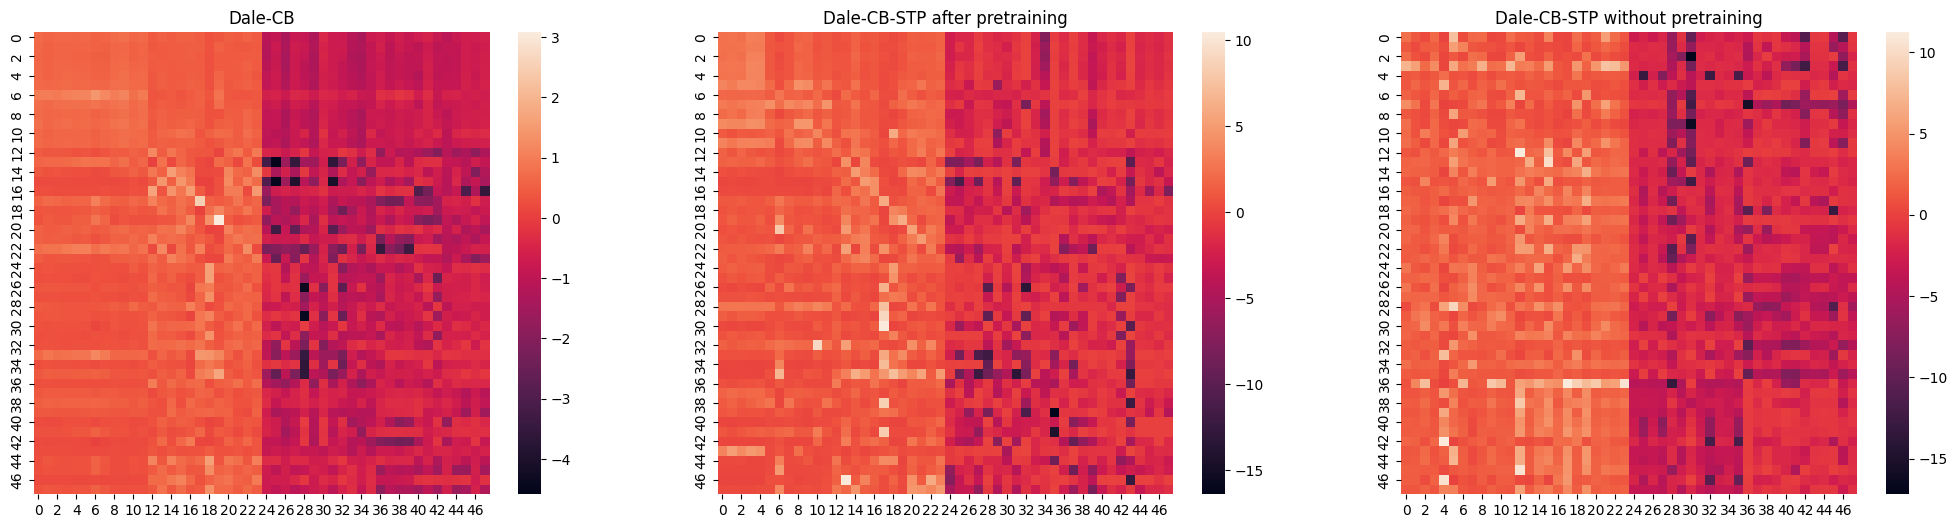

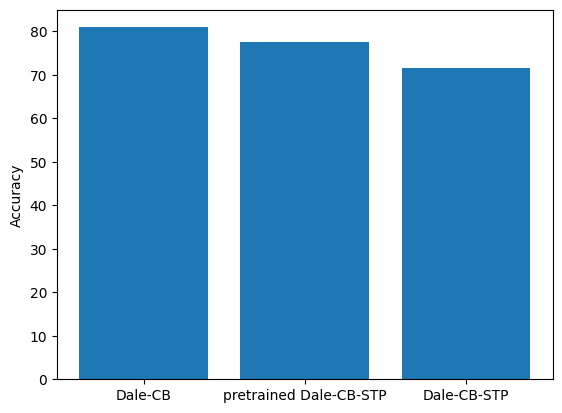

In [ ]:
# W1 is the weight from Dale-CB
# W2 is the weight from Dale-CB-STP after pretraining
# W3 is the weight from Dale-CB-STP without pretraining
with open('weights/05_Dale-CB_48.pkl', 'rb') as f:
    P, W1, read_out, K, C, P_z, b_z, e_e, e_i, b_v = pickle.load(f)
    f.close()

with open('weights/pretrained_Dale-CB-STP.pkl', 'rb') as f:
    P, W2, read_out, K, C, P_z, b_z, e_e, e_i, b_v, Ucap= pickle.load(f)
    f.close()

with open('weights/07_Dale-CB-STP_48.pkl', 'rb') as f:
    P, W3, read_out, K, C, P_z, b_z, e_e, e_i, b_v, Ucap, c_U, c_u, c_x= pickle.load(f)
    f.close()

# plot heatmap of W1 and W2
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(25, 6))
sns.heatmap(W1, ax=ax[0])
ax[0].set_title('Dale-CB')
sns.heatmap(W2, ax=ax[1])
ax[1].set_title('Dale-CB-STP after pretraining')
sns.heatmap(W3, ax=ax[2])
ax[2].set_title('Dale-CB-STP without pretraining')

# compare their performance
perf = [80.93 ,77.46, 71.63]
labels = ['Dale-CB', 'pretrained Dale-CB-STP', 'Dale-CB-STP']
fig, ax = plt.subplots()
ax.bar(labels, perf)
ax.set_ylabel('Accuracy')
plt.show()

Text(0.5, 1.0, 'Performance of permuted MNIST')

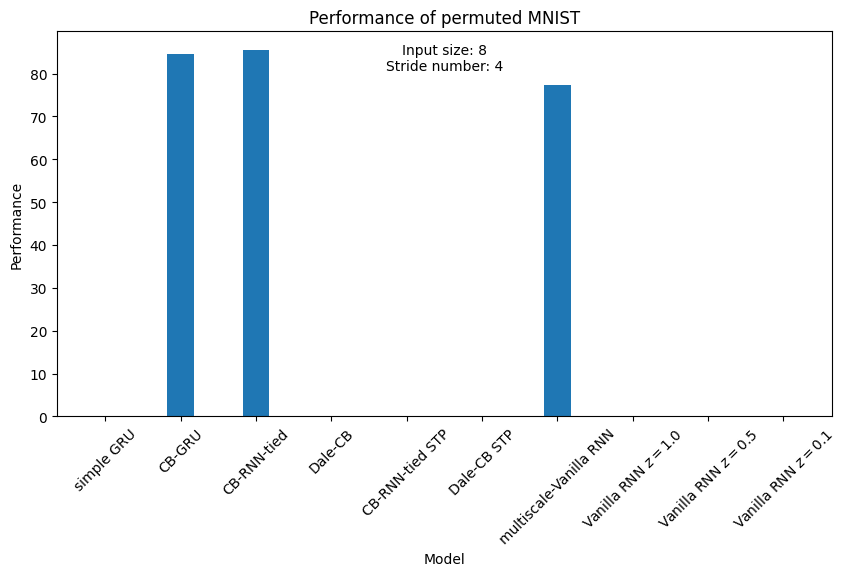

In [14]:
# Performance bar plot
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))
# rotate model name

model_name = ['simple GRU', 'CB-GRU', 'CB-RNN-tied', 'Dale-CB', 'CB-RNN-tied STP', 'Dale-CB STP', 'multiscale-Vanilla RNN', 'Vanilla RNN $z=1.0$', 'Vanilla RNN $z=0.5$', 'Vanilla RNN $z=0.1$']
perf1 = [0, 84.53, 85.55, 0, 0, 0, 77.38, 0, 0, 0]

bar_width = 0.35

plt.bar(model_name, perf1, bar_width, label='48 Neurons')
index = np.arange(len(model_name))
# text bar to show input size, stride number, and hidden size
plt.text(4.5, 80, f'Input size: {input_size}\nStride number: {stride_number}'.format(input_size=input_size, stride_number=stride_number, hidden_size=hidden_size), ha='center', va='bottom')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.ylabel('Performance')
plt.title('Performance of permuted MNIST')
